In [1]:
import os
import sys
import gin
import numpy as np
import pandas as pd
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import matplotlib
import matplotlib.pyplot as plt
#import matplotlib.pyplot as plt
from ariadne.transformer.model import HFPerceiver
import ariadne.transformations  as trn
from ariadne.utils.model import get_checkpoint_path, weights_update
import torch
import seaborn as sns
import torch.nn.functional as f
%matplotlib notebook
%load_ext autoreload
%autoreload 2

Load data

In [2]:
params = {
                    "sep": '\s+',
                    #"nrows": 10000,
                    "encoding": 'utf-8',
                    "names":  ['event',  'x', 'y', 'z', 'station',
                               'track', 'px', 'py', 'pz', 'X0', 'Y0', 'Z0', 'label']
                 }
data = pd.read_csv(os.path.join('D:/','data','spd','100.tsv'), **params)

In [3]:
data.describe()

event             x             y             z       station  \
count  23863.000000  23863.000000  23863.000000  23863.000000  23863.000000   
mean      48.299292      3.190656      2.362883    -26.755876     17.741860   
std       29.574746    307.840663    306.653571    812.261780     10.095624   
min        0.000000   -579.999769   -580.126741  -2383.393486      0.000000   
25%       21.000000   -276.223136   -269.750976   -387.307831      9.000000   
50%       47.000000     15.757623      1.195971    -52.821597     18.000000   
75%       74.000000    273.437408    277.350495    350.216797     27.000000   
max       99.000000    580.100657    580.031520   2385.947703     35.000000   

              track            px            py            pz            X0  \
count  23863.000000  23863.000000  23863.000000  23863.000000  23863.000000   
mean       1.950300      0.522095      1.606861    -19.711935      0.120100   
std        2.546237    377.890953    361.532224    645.105564      9.000523   
min       -1.000000   -986.583598   -940.387462  -6167.109458    -23.039747   
25%        0.000000   -171.473862   -183.434315   -192.840203     -3.915116   
50%        1.000000      0.000000      0.000000      0.000000      0.000000   
75%        4.000000    198.353110    180.134905    126.442808      5.254307   
max        8.000000    965.265228    989.441053   5609.916599     22.599823   

                 Y0            Z0  label  
count  23863.000000  23863.000000    0.0  
mean       0.320028    -10.778280    NaN  
std        9.348745    151.109597    NaN  
min      -30.488571   -287.733199    NaN  
25%       -4.791163   -129.294855    NaN  
50%        0.000000      0.000000    NaN  
75%        5.752906     88.158922    NaN  
max       27.301398    299.245439    NaN

In [4]:
def visualize_simple_3d(data, axes=['x','y','z'], titleAx=['X', 'Y', 'Z'], title=None, scatter_params_true=None, scatter_params_false=None):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    if not scatter_params_true:
        scatter_params_true = {}
    if not scatter_params_false:
        scatter_params_true = {}
    true_els = data[data['track']!=-1]
    false_els = data[data['track']==-1]
    ax.scatter(true_els[axes[0]], true_els[axes[1]],true_els[axes[2]], **scatter_params_true)
    ax.scatter(false_els[axes[0]], false_els[axes[1]], false_els[axes[2]], **scatter_params_false)
    
    ax.set_xlabel(titleAx[0])
    ax.set_ylabel(titleAx[1])
    ax.set_zlabel(titleAx[2])
    if title:
        plt.title(title)
    plt.tight_layout()
    plt.show()

In [5]:
events = data.groupby('event')

Let's check how event is loaded

<IPython.core.display.Javascript object>


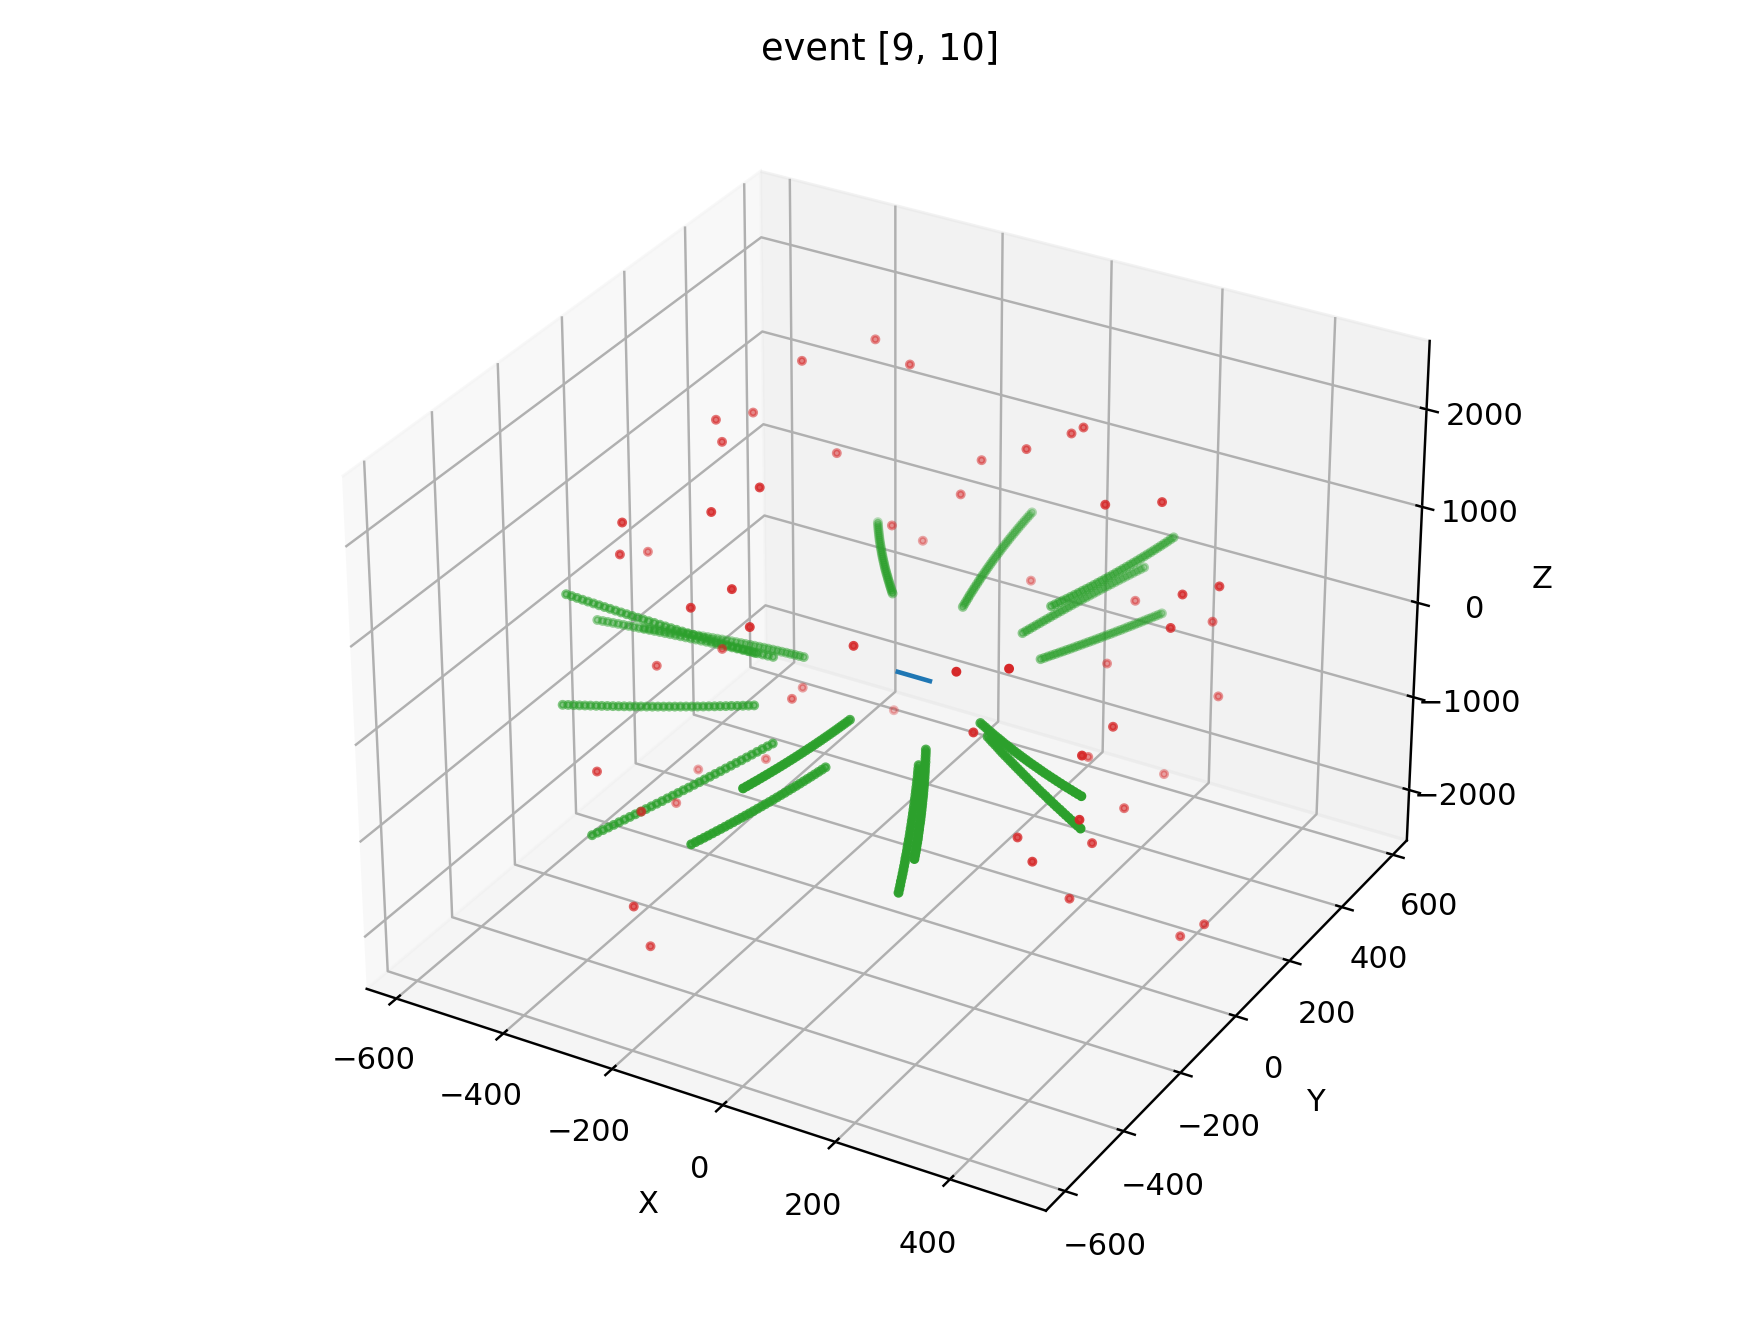

In [6]:
event_nums = [9, 10]
visualize_simple_3d(data[data.event.isin(event_nums)], title=f'event {event_nums}', scatter_params_true={'c':'tab:green', 's':5}, scatter_params_false={'c':'tab:red', 's':5})

To change parameters of models (which are gin configurable) i enter interactive mode of gin (may be redundant)

In [7]:
gin.enter_interactive_mode()

Load model with basic parameters. Later check if model meets config file of checkpoint

In [243]:
from ariadne.pct.model import PCTSegment
model = PCTSegment(n_points=512)
# D:\projects\ariadne\lightning_logs\PCTSegment\version_37\epoch=82-step=4150.ckpt
model = weights_update(model=model,
                           checkpoint=torch.load("D:/projects/ariadne/lightning_logs/PCTSegment/version_169/epoch=1-step=500.ckpt"))


Load event to test, perform necessary transformations.

In [244]:
event = data[data.event.isin([15])]
transforms = trn.Compose([
    trn.ConstraintsNormalize(use_global_constraints = True, columns=('x', 'y', 'z'), constraints = {
    'x': [-600., 600.], 'y': [-600, 600.], 'z': [-2386., 2386.]
})])
event_t = transforms(event)

In [245]:
event_t.describe()

event           x           y           z     station       track  \
count  294.0  294.000000  294.000000  294.000000  294.000000  294.000000   
mean    15.0   -0.040167    0.021160   -0.108363   17.462585    1.500000   
std      0.0    0.525251    0.494171    0.372218   10.249297    2.144522   
min     15.0   -0.966432   -0.887168   -0.982937    0.000000   -1.000000   
25%     15.0   -0.530912   -0.352429   -0.230113    8.000000   -1.000000   
50%     15.0   -0.037244   -0.056210   -0.101090   17.000000    1.000000   
75%     15.0    0.388237    0.507635    0.028028   27.000000    3.000000   
max     15.0    0.966351    0.956949    0.960501   35.000000    5.000000   

               px          py          pz          X0          Y0          Z0  \
count  294.000000  294.000000  294.000000  294.000000  294.000000  294.000000   
mean   -53.168559   12.837581  -68.477955    2.365381   -1.259844 -187.273574   
std    329.697497  305.932230  202.092785    1.498549    0.798154  118.644155   
min   -874.519044 -680.999585 -389.409146    0.000000   -1.763781 -262.183003   
25%    -94.753350   -7.811742 -260.853984    0.000000   -1.763781 -262.183003   
50%      0.000000    0.000000    0.000000    3.311534   -1.763781 -262.183003   
75%     97.096378   61.986522   51.242015    3.311534    0.000000    0.000000   
max    313.100758  421.030554  235.241853    3.311534    0.000000    0.000000   

       label        index  
count    0.0   294.000000  
mean     NaN  4339.500000  
std      NaN    85.014705  
min      NaN  4193.000000  
25%      NaN  4266.250000  
50%      NaN  4339.500000  
75%      NaN  4412.750000  
max      NaN  4486.000000

<IPython.core.display.Javascript object>


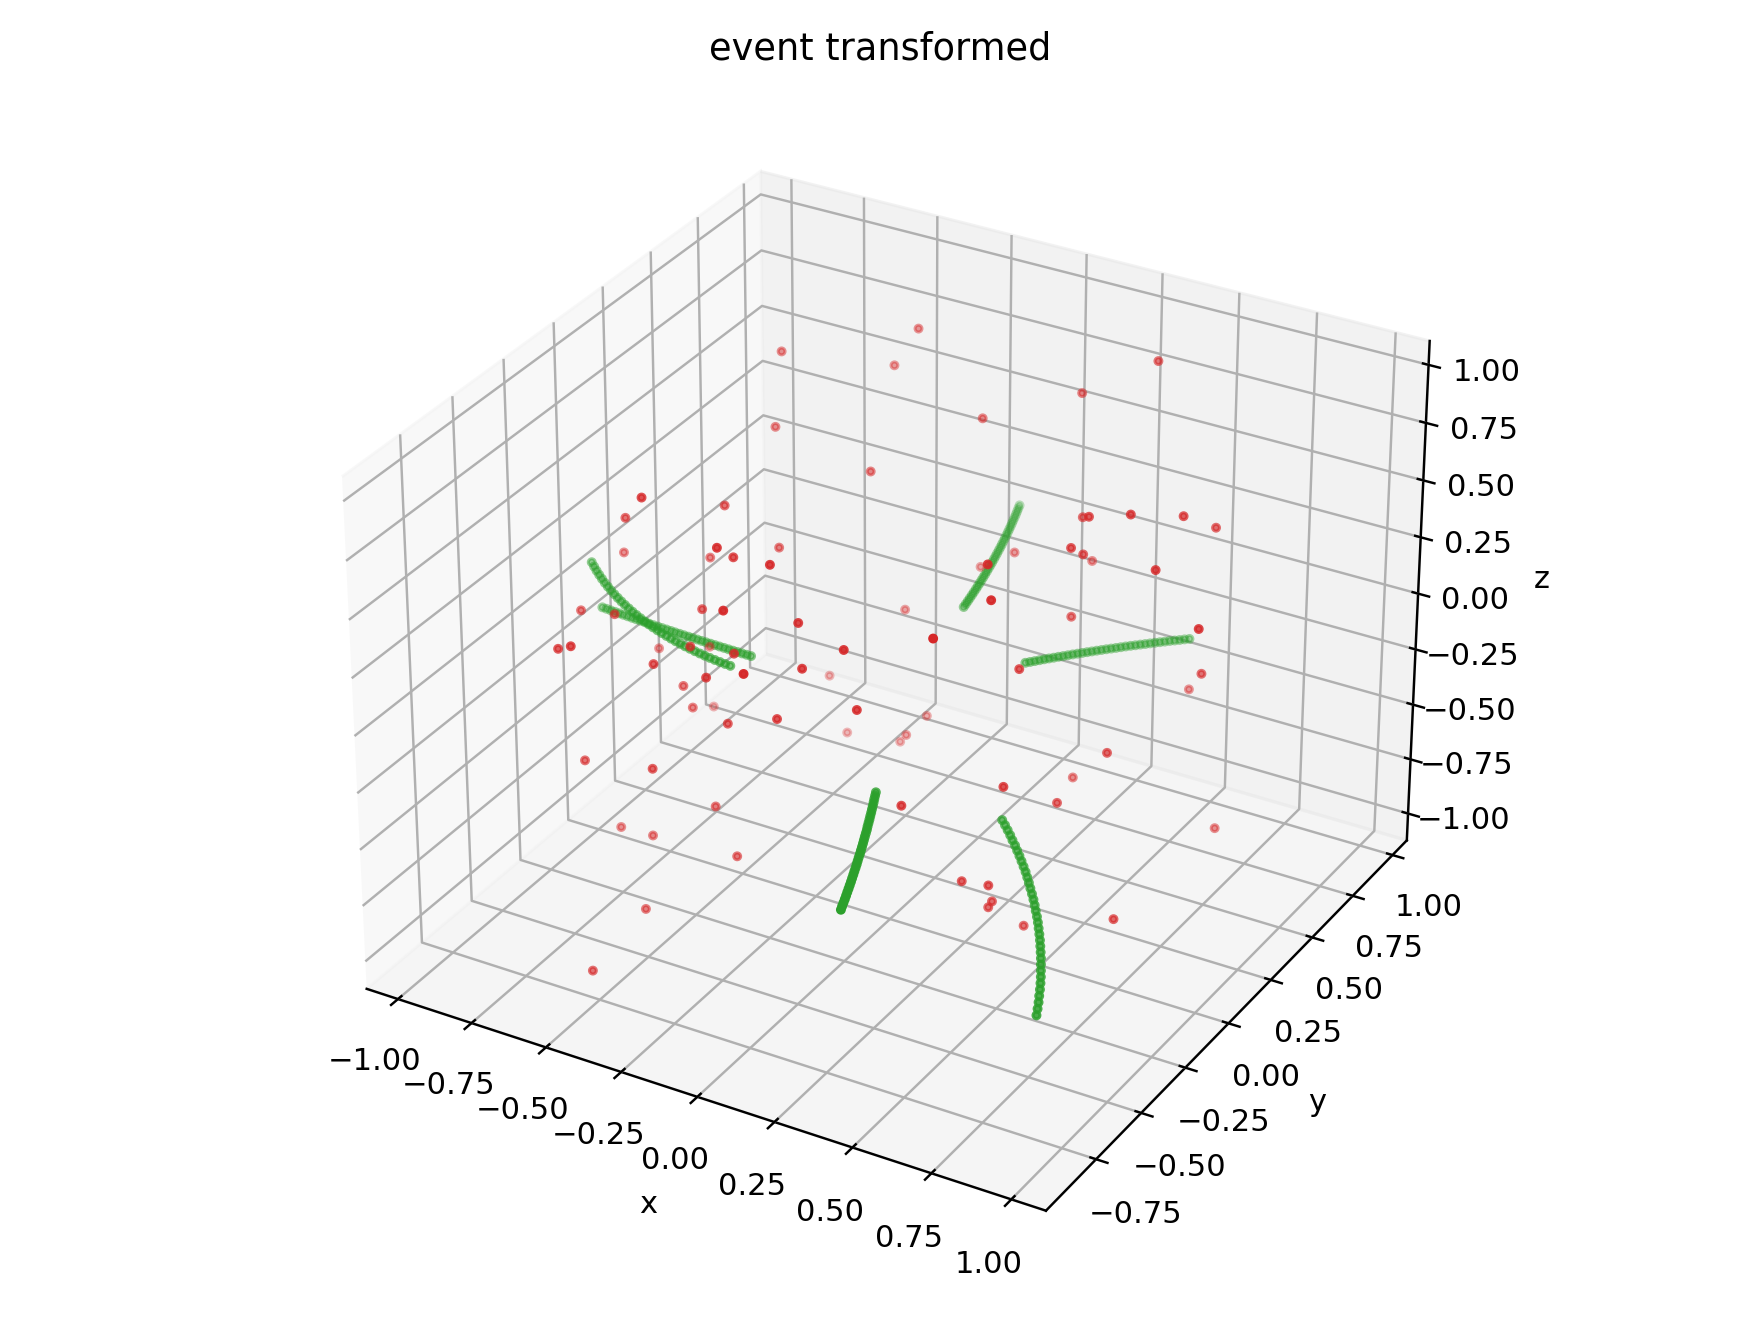

In [246]:
visualize_simple_3d(event_t, title='event transformed', scatter_params_true={'c':'tab:green', 's':5}, scatter_params_false={'c':'tab:red', 's':5}, axes=['x','y', 'z'], titleAx=['x', 'y', 'z'])

Change event to prepare x and y. X must be in format [ N, C]. This may change later after i fix input dimensions in model

In [247]:
event_t = event_t.sample(frac = 1)

In [248]:
event_t

event         x         y         z  station  track          px  \
4459     15 -0.509098 -0.767597 -0.982937       31     -1    0.000000   
4266     15  0.234288  0.436724 -0.176743        4      2  259.895677   
4407     15  0.422498 -0.313291 -0.537881        5     -1    0.000000   
4237     15  0.552892 -0.196696 -0.506602       10      1   89.383566   
4308     15  0.258228 -0.543933 -0.192250       11      3  268.911400   
...     ...       ...       ...       ...      ...    ...         ...   
4249     15  0.688894 -0.342013 -0.638639       22      1   69.159330   
4444     15  0.190938 -0.554829  0.544842        9     -1    0.000000   
4401     15 -0.951633 -0.001936 -0.095836       34      5 -872.142633   
4272     15  0.284172  0.513320 -0.189063       10      2  270.568502   
4438     15  0.500620 -0.101391 -0.865516        4     -1    0.000000   

              py          pz        X0        Y0          Z0  label  index  
4459    0.000000    0.000000  0.000000  0.000000    0.000000    NaN   4459  
4266  411.477435 -260.853984  3.311534 -1.763781 -262.183003    NaN   4266  
4407    0.000000    0.000000  0.000000  0.000000    0.000000    NaN   4407  
4237  -75.149901 -307.323741  3.311534 -1.763781 -262.183003    NaN   4237  
4308 -663.569090 -389.409146  3.311534 -1.763781 -262.183003    NaN   4308  
...          ...         ...       ...       ...         ...    ...    ...  
4249  -94.095253 -307.323741  3.311534 -1.763781 -262.183003    NaN   4249  
4444    0.000000    0.000000  0.000000  0.000000    0.000000    NaN   4444  
4401   64.433222   51.242015  3.311534 -1.763781 -262.183003    NaN   4401  
4272  404.539403 -260.853984  3.311534 -1.763781 -262.183003    NaN   4272  
4438    0.000000    0.000000  0.000000  0.000000    0.000000    NaN   4438  

[294 rows x 14 columns]

In [249]:
event_x = event_t[['x', 'y', 'z']].values.T #(event_t[['r', 'phi', 'z']].values / [1., np.pi, 1.]).T

In [250]:
event_y = event_t['track'] != -1

In [251]:
event_y

4459    False
4266     True
4407    False
4237     True
4308     True
        ...  
4249     True
4444    False
4401     True
4272     True
4438    False
Name: track, Length: 294, dtype: bool

In [252]:
event_x.shape

(3, 294)

In [253]:
event_y.shape

(294,)

In [254]:
input_event = torch.from_numpy(np.swapaxes(event_x, -1, -2)).unsqueeze(0).float()

In [255]:
input_event.size()

torch.Size([1, 294, 3])

Add zeros to get number of inputs suitable for model. Create mask to mask attention and metrics later.

In [256]:
input_event.size(1)

294

In [257]:
event_changed = torch.zeros((input_event.size(0), 512, input_event.size(2)))
event_changed[:, :input_event.size(1), :input_event.size(2) ] = input_event

In [258]:
event_changed.size()

torch.Size([1, 512, 3])

In [259]:
mask = torch.zeros((input_event.size(0), 512), dtype=torch.bool)
mask[:, :input_event.size(1)] = 1

In [260]:
mask.size()

torch.Size([1, 512])

In [261]:
inputs = {'x': event_changed, 'mask': mask }

In [266]:
inputs['x']

tensor([[[-0.5091, -0.7676, -0.9829],
         [ 0.2343,  0.4367, -0.1767],
         [ 0.4225, -0.3133, -0.5379],
         ...,
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000]]])

In [267]:
inputs['mask']

tensor([[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  

Produce outputs

In [268]:
model.eval()
result = model(x=inputs['x'], mask=inputs['mask'] )

In [269]:
result.shape

torch.Size([1, 512, 1])

In [270]:
result = result.squeeze()

In [271]:
result

tensor([-10.7005,   3.2079,  -1.6830,   1.3168,   3.6018, -12.2573,   0.5363,
          3.6943,   3.1891,  -2.6835, -13.6543,   2.6633,   5.1649,   5.6754,
        -10.9594,   3.4194,  -9.8421,   4.1486,   0.5150,   7.6080,   2.8946,
          6.8080,  -1.6280,   1.0583,   4.0259,   3.5312,   3.6082,  -6.9022,
         -5.9144,   5.9718,  -9.3088,   4.9083,   1.6559,   2.8531, -13.3250,
          5.7741, -10.6587,   4.3403,   4.6230,   0.2607,   2.9430,   7.9785,
          3.3296, -11.7864,   2.4712,   2.0887,   0.9209,   0.4363,  -9.4227,
          5.6157,   5.7352,   3.0178, -10.2273,  -1.3429,   4.4517,   0.5283,
          3.1728,   3.9192,   1.2997,  -6.2665,   3.1430,   2.3306, -12.1261,
         -4.6596,   0.8299,   5.8999,   3.4036,  -7.0021,   5.7504,   3.4744,
          2.0638,   2.7715, -10.0359,   0.8526,   3.4863,   4.3969,   4.7194,
          0.5426,   3.2515,  -6.7913,   3.5208,   0.6716,  -5.3362,   6.3651,
         -0.7500,   4.3045, -10.5328,   3.5884, -10.0192,   0.60

In [272]:
result.detach().cpu().numpy()[:input_event.size(1)].max()

7.9785175

In [273]:
result.detach().cpu().numpy()[:input_event.size(1)].min()

-16.164146

Check logits distribution

In [55]:
sns.distplot(result[:input_event.size(1)].detach().cpu().numpy())

<Axes3DSubplot: title={'center': 'event [9, 10]'}, xlabel='X', ylabel='Y', zlabel='Z'>

Get final result with scores and metrics

In [274]:
result = f.sigmoid(result) 

In [275]:
result

tensor([2.2534e-05, 9.6113e-01, 1.5670e-01, 7.8865e-01, 9.7345e-01, 4.7501e-06,
        6.3094e-01, 9.7574e-01, 9.6042e-01, 6.3954e-02, 1.1750e-06, 9.3483e-01,
        9.9432e-01, 9.9658e-01, 1.7393e-05, 9.6831e-01, 5.3163e-05, 9.8446e-01,
        6.2597e-01, 9.9950e-01, 9.4758e-01, 9.9890e-01, 1.6411e-01, 7.4236e-01,
        9.8247e-01, 9.7156e-01, 9.7361e-01, 1.0045e-03, 2.6929e-03, 9.9746e-01,
        9.0618e-05, 9.9267e-01, 8.3969e-01, 9.4548e-01, 1.6331e-06, 9.9690e-01,
        2.3495e-05, 9.8713e-01, 9.9027e-01, 5.6482e-01, 9.4993e-01, 9.9966e-01,
        9.6543e-01, 7.6072e-06, 9.2210e-01, 8.8980e-01, 7.1522e-01, 6.0738e-01,
        8.0863e-05, 9.9637e-01, 9.9678e-01, 9.5337e-01, 3.6168e-05, 2.0704e-01,
        9.8848e-01, 6.2909e-01, 9.5980e-01, 9.8053e-01, 7.8578e-01, 1.8952e-03,
        9.5863e-01, 9.1138e-01, 5.4163e-06, 9.3816e-03, 6.9634e-01, 9.9727e-01,
        9.6782e-01, 9.0915e-04, 9.9683e-01, 9.6995e-01, 8.8733e-01, 9.4112e-01,
        4.3796e-05, 7.0111e-01, 9.7030e-

In [276]:
result = result > 0.5
result = result.to(int)[:input_event.size(1)]

In [277]:
result 

tensor([0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1,
        0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
        1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
        0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1,
        0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1,
        0, 0, 0, 1, 1, 0])

In [278]:
labels = event_y
labels

4459    False
4266     True
4407    False
4237     True
4308     True
        ...  
4249     True
4444    False
4401     True
4272     True
4438    False
Name: track, Length: 294, dtype: bool

In [279]:
labels.value_counts()

True     210
False     84
Name: track, dtype: int64

Точность по всему событию

In [280]:
(labels == np.array(result)).sum() / len(labels)

0.9319727891156463

Точность по фейкам

In [281]:
fakes = labels < 1

In [282]:
(labels[fakes] == np.array(result)[fakes]).sum() / len(labels[fakes])

0.9642857142857143

Точность по трекам

In [283]:
(labels[~fakes] == np.array(result)[~fakes]).sum() / len(labels[~fakes])

0.919047619047619

Общая визуализация

In [284]:
def visualize_preds_targets_3d(data_true,
                               preds,
                               axes=['x','y','z'], 
                               titleAx=['X', 'Y', 'Z'], 
                               title=None, 
                               scatter_params_true=None, 
                               scatter_params_false=None,
                               ):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    if not scatter_params_true:
        scatter_params_true = {}
    if not scatter_params_false:
        scatter_params_true = {}
    data_true['label'] = (data['track']!=-1).astype('int')
    true_els = data_true[data_true['label']==preds]
    false_els = data_true[data_true['label']!=preds]
    ax.scatter(true_els[axes[0]], true_els[axes[1]],true_els[axes[2]], **scatter_params_true)
    ax.scatter(false_els[axes[0]], false_els[axes[1]], false_els[axes[2]], **scatter_params_false)
    
    ax.set_xlabel(titleAx[0])
    ax.set_ylabel(titleAx[1])
    ax.set_zlabel(titleAx[2])
    if title:
        plt.title(title)
    plt.tight_layout()
    plt.show()

<IPython.core.display.Javascript object>


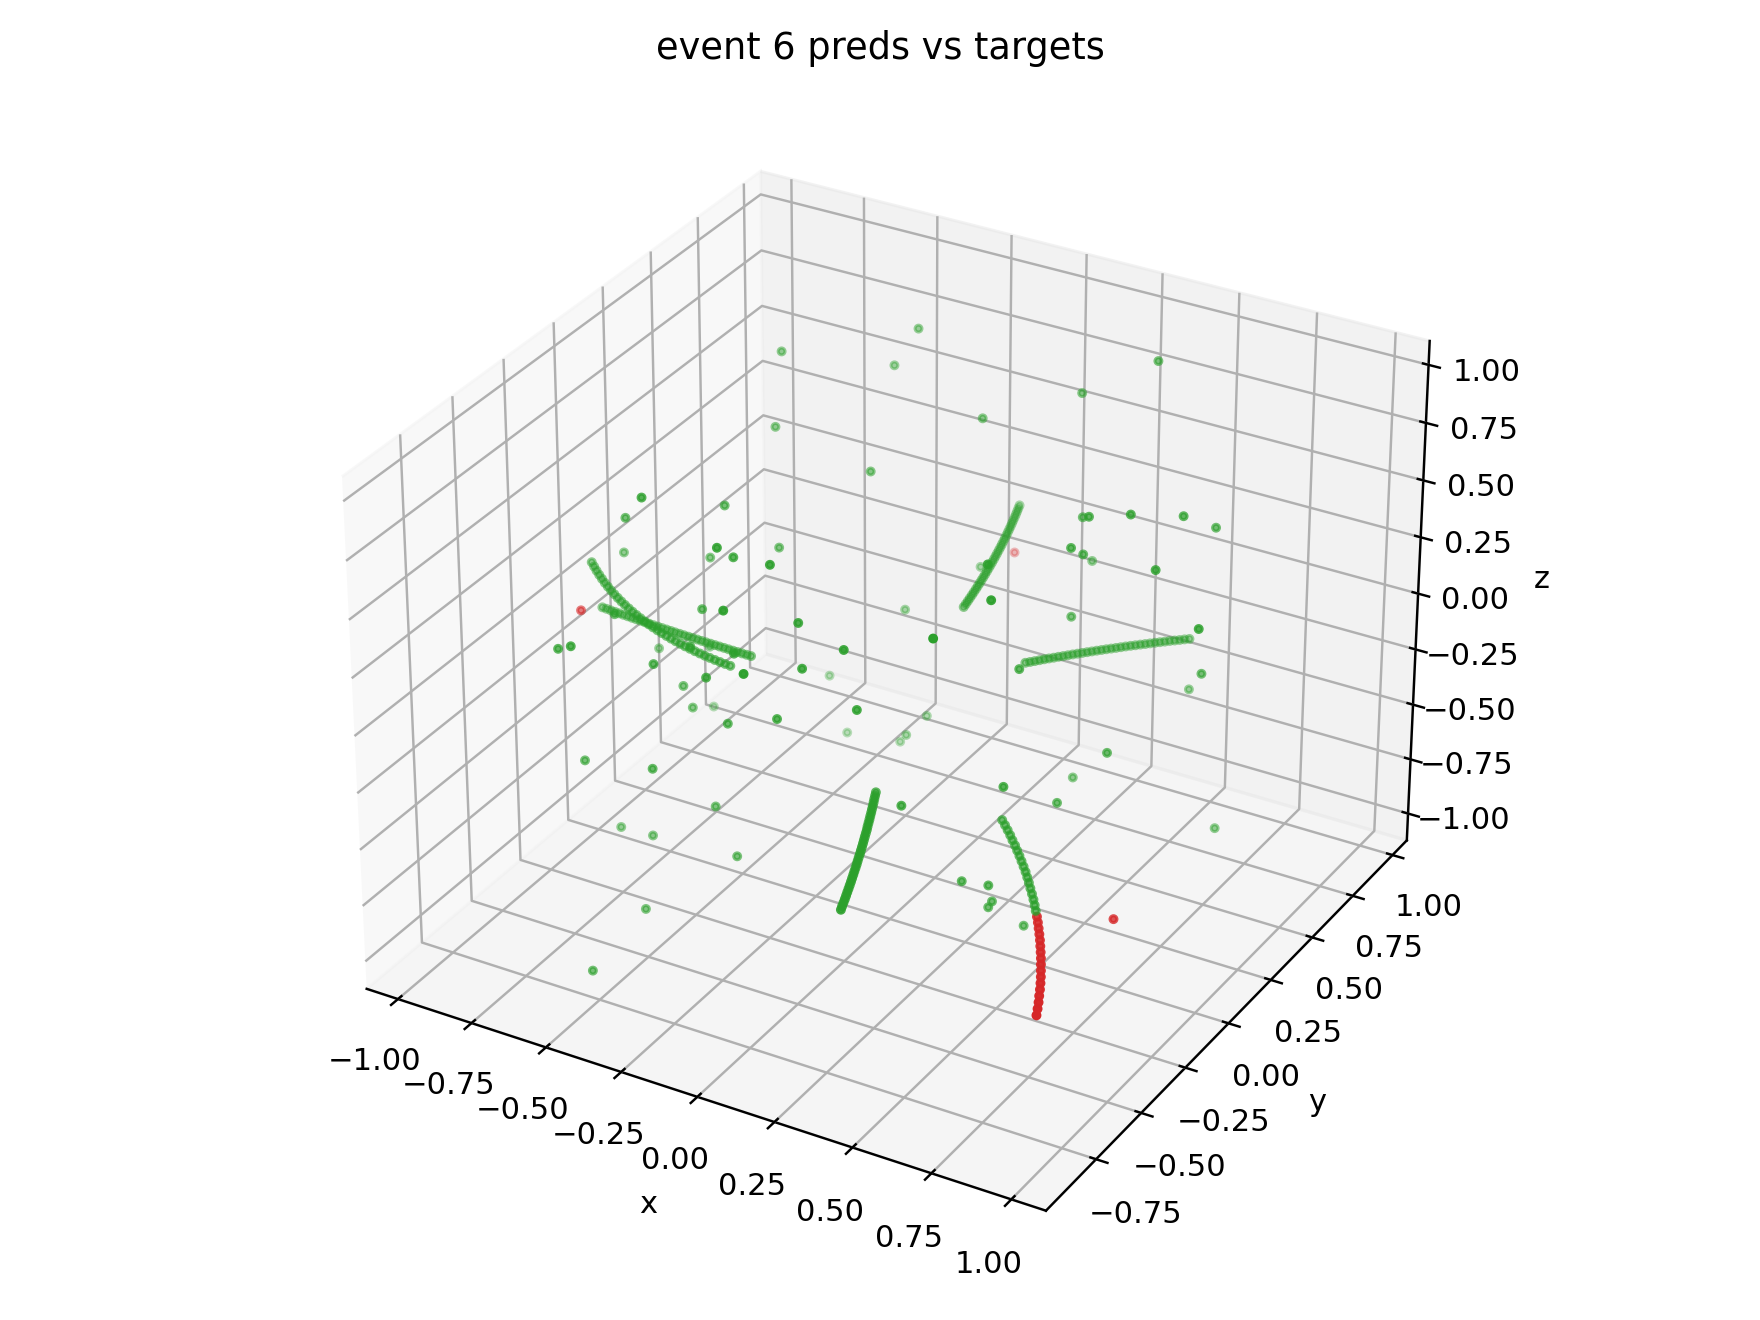

In [285]:
visualize_preds_targets_3d(event_t, np.array(result), title='event 6 preds vs targets', scatter_params_true={'c':'tab:green', 's':5}, scatter_params_false={'c':'tab:red', 's':5}, axes=['x', 'y', 'z'], titleAx=['x', 'y', 'z'])

In [286]:
def get_results_for_event(event_nums=[1,2]):
    len_mult = len(event_nums)
    event = data[data.event.isin(event_nums)]
    transforms = trn.Compose([
        trn.ConstraintsNormalize(use_global_constraints = True, columns=('x', 'y', 'z'), constraints = {
        'x': [-600., 600.], 'y': [-600, 600.], 'z': [-2386., 2386.]
    })])
    event_t = transforms(event)
    event_t = event_t.sample(frac = 1)
    event_x = event_t[['x', 'y', 'z']].values.T #(event_t[['r', 'phi', 'z']].values / [1., np.pi, 1.]).T
    event_y = event_t[event_t['track'] != -1]
    input_event = torch.from_numpy(np.swapaxes(event_x, -1, -2)).unsqueeze(0).float()
    event_changed = torch.ones((input_event.size(0), 512*len_mult, input_event.size(2)))*-9.
    event_changed[:, :input_event.size(1), :input_event.size(2) ] = input_event
    mask = torch.zeros((input_event.size(0), 512*len_mult), dtype=torch.bool)
    mask[:input_event.size(1)] = 1
    inputs = {'x': event_changed, 'mask': mask }
    result = model(x=inputs['x'], mask=inputs['mask'] )
    result = result.squeeze()
    result = f.sigmoid(result) > 0.5
    result = result.to(int)[:input_event.size(1)]
    labels = (event_t['track'] != -1).astype('int')
    print(f"Accuracy is {(labels == np.array(result)).sum() / len(labels)} ")
    print(f"Precision is {(labels[labels>0.5] == np.array(result)[labels>0.5]).sum() / np.array(result).sum()} ")
    print(f"Recall is {(labels[labels>0.5] == np.array(result)[labels>0.5]).sum() / labels.sum()} ")
    visualize_preds_targets_3d(event_t, np.array(result), title=f'events {event_nums} preds vs targets', scatter_params_true={'c':'tab:green', 's':5}, scatter_params_false={'c':'tab:red', 's':5}, axes=['x', 'y', 'z'], titleAx=['x', 'y', 'z'])

Accuracy is 0.877742946708464 
Precision is 0.877742946708464 
Recall is 1.0 


<IPython.core.display.Javascript object>


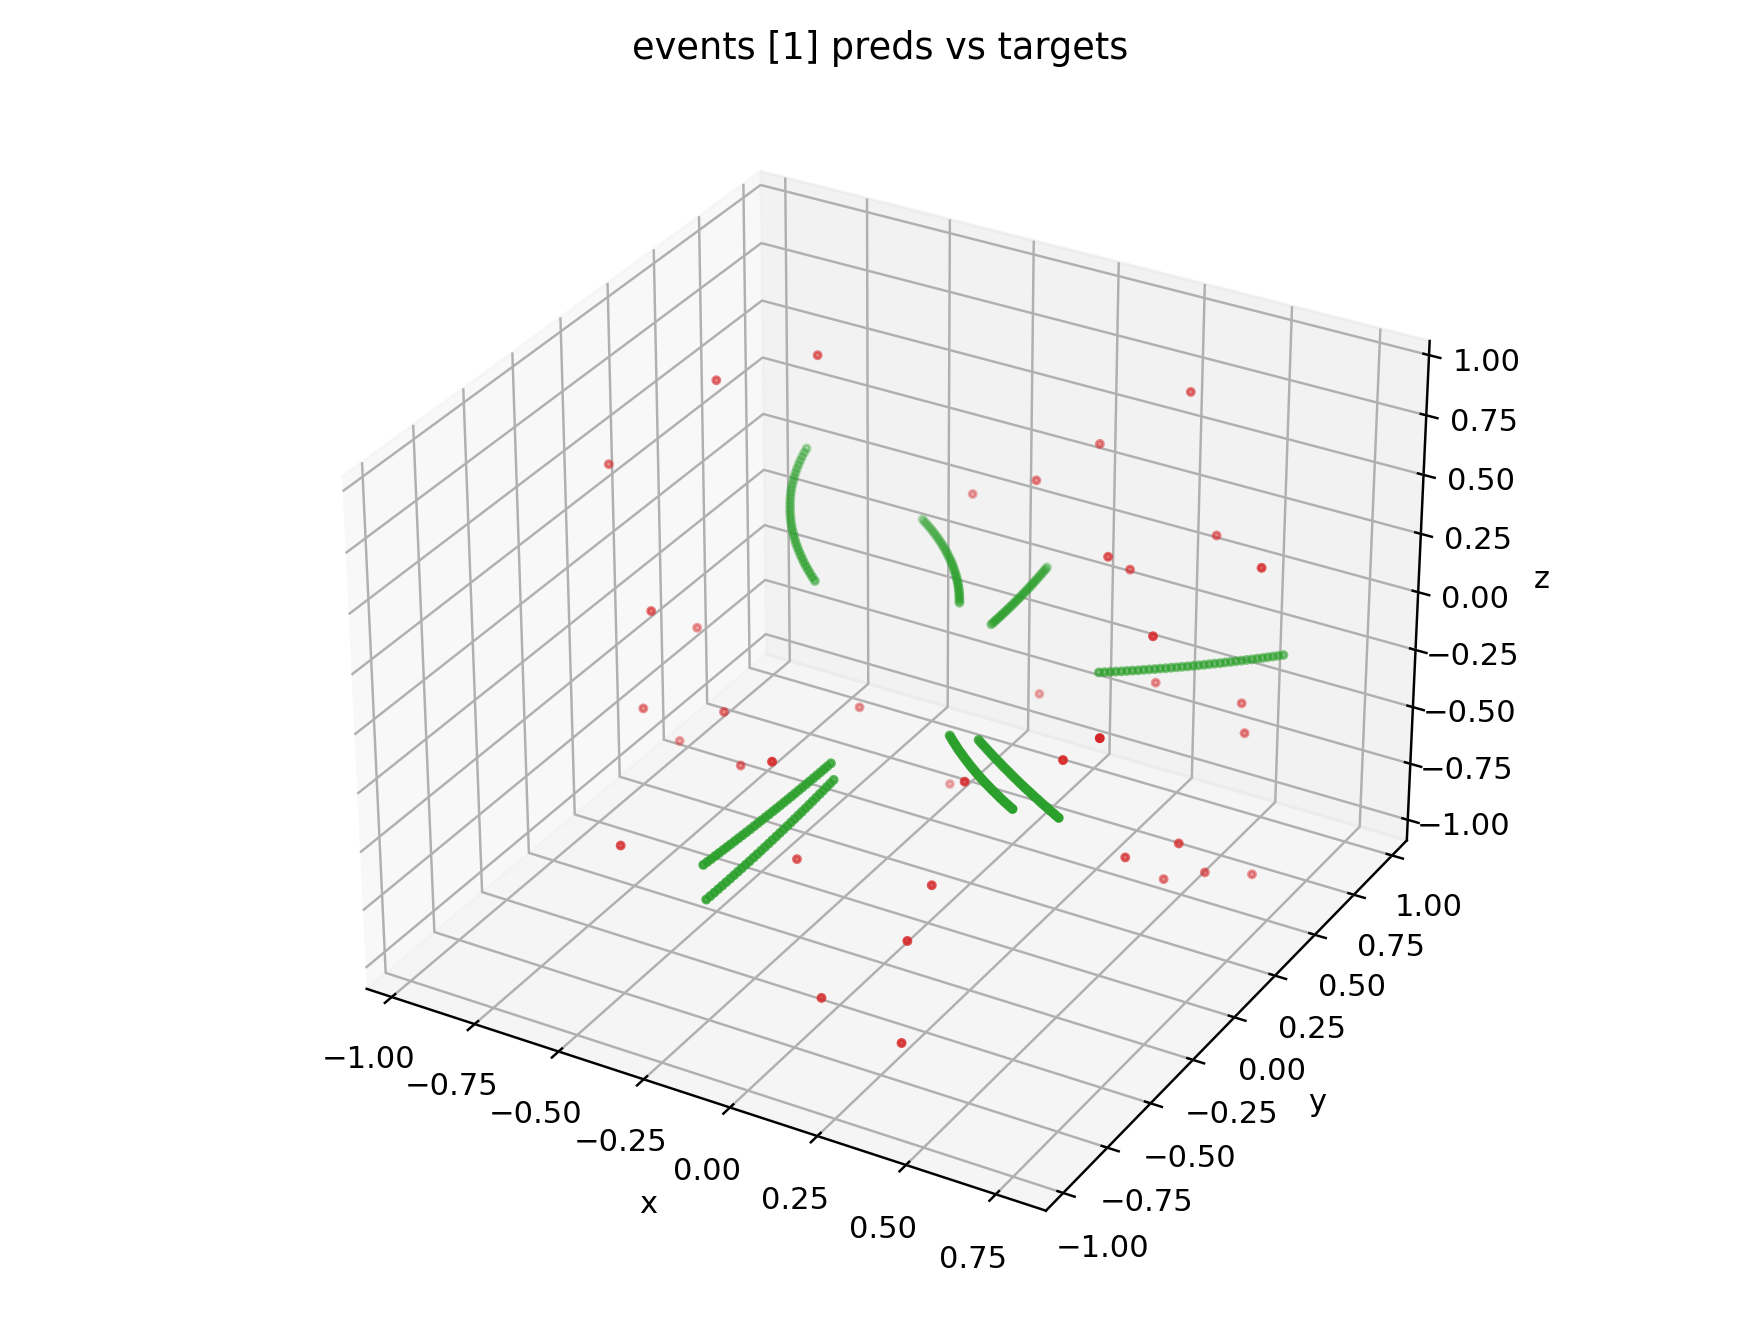

In [288]:
get_results_for_event([1])

Accuracy is 0.8200836820083682 
Precision is 0.860655737704918 
Recall is 0.9 


<IPython.core.display.Javascript object>


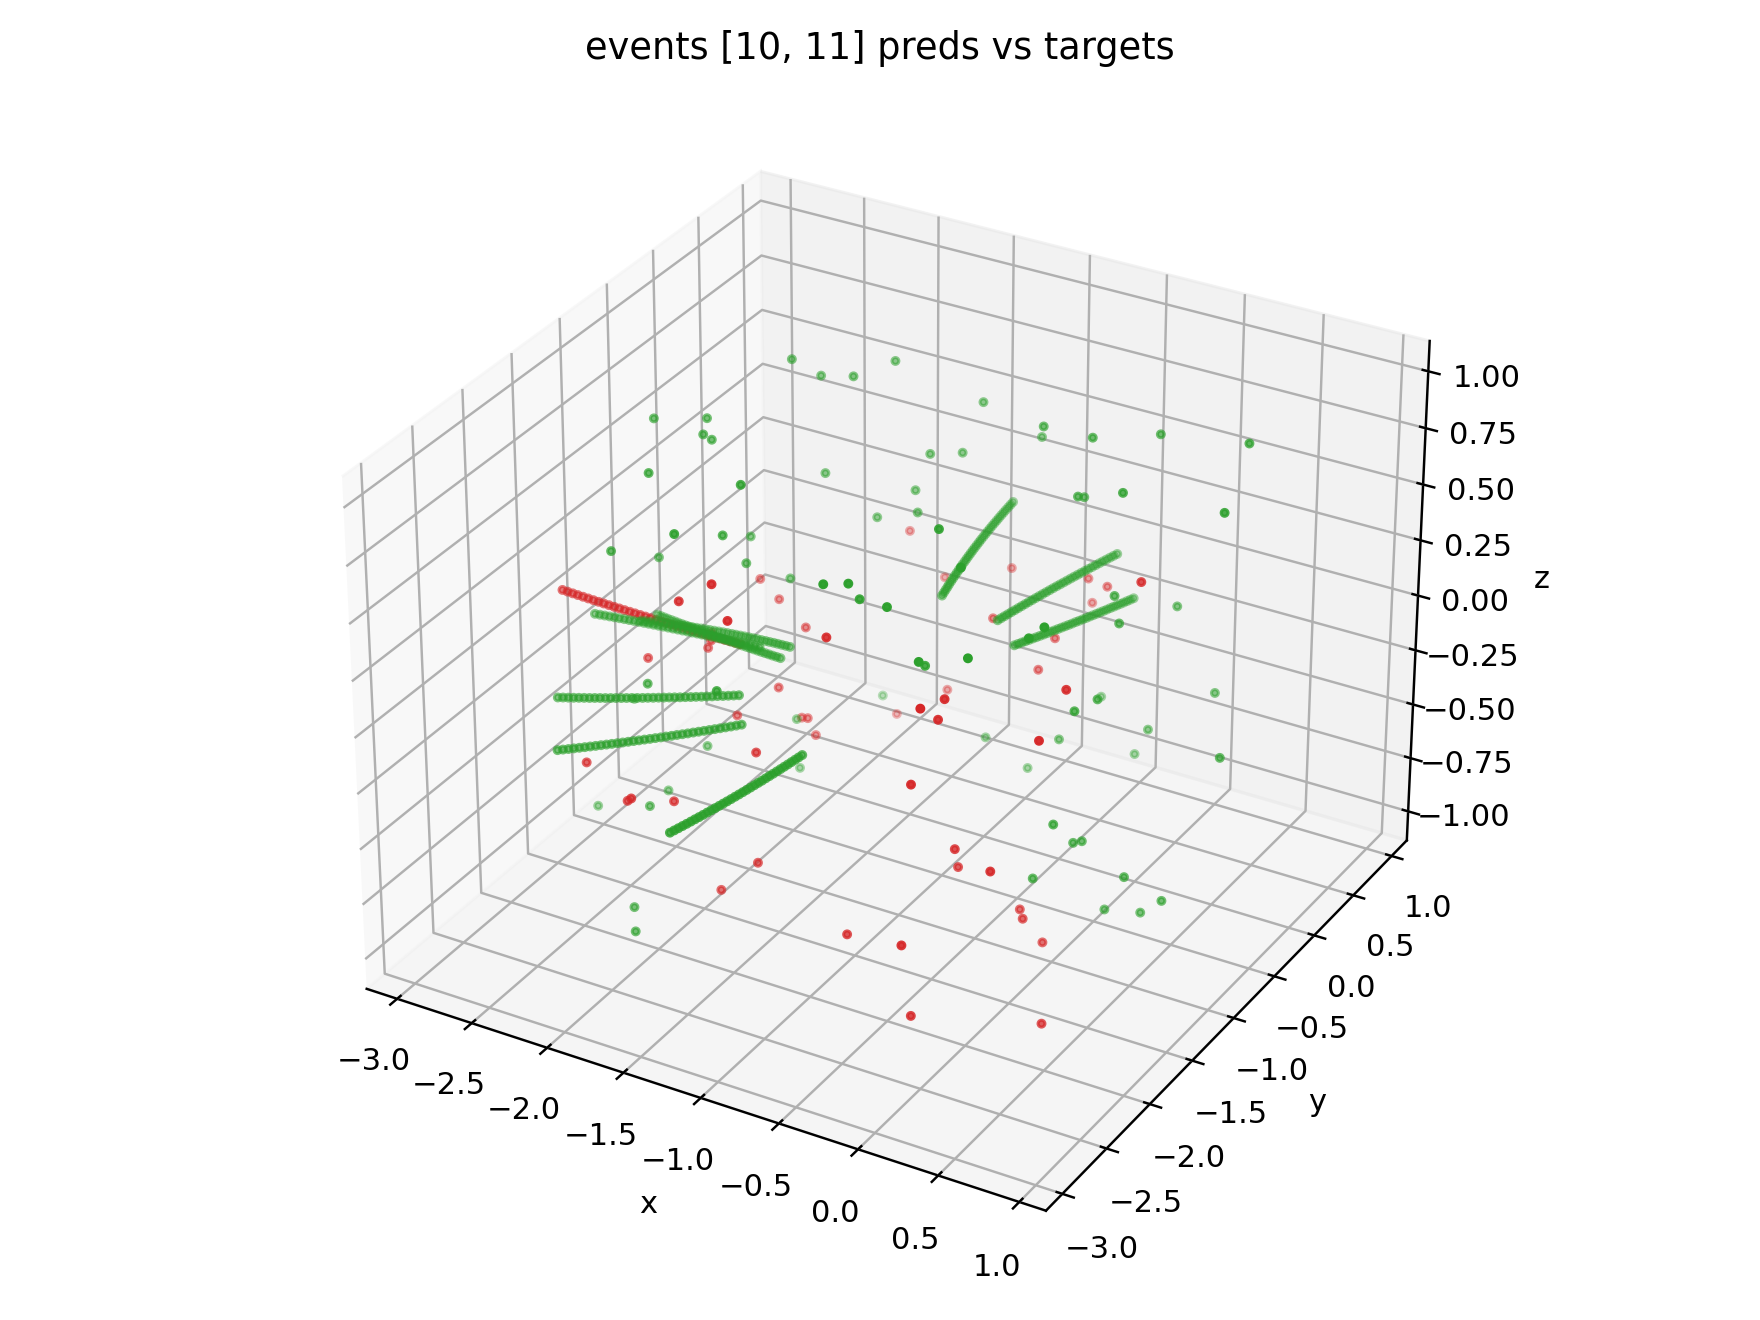

In [60]:
get_results_for_event([10,11])

Accuracy is 0.8262626262626263 
Precision is 0.9489247311827957 
Recall is 0.8404761904761905 


<IPython.core.display.Javascript object>


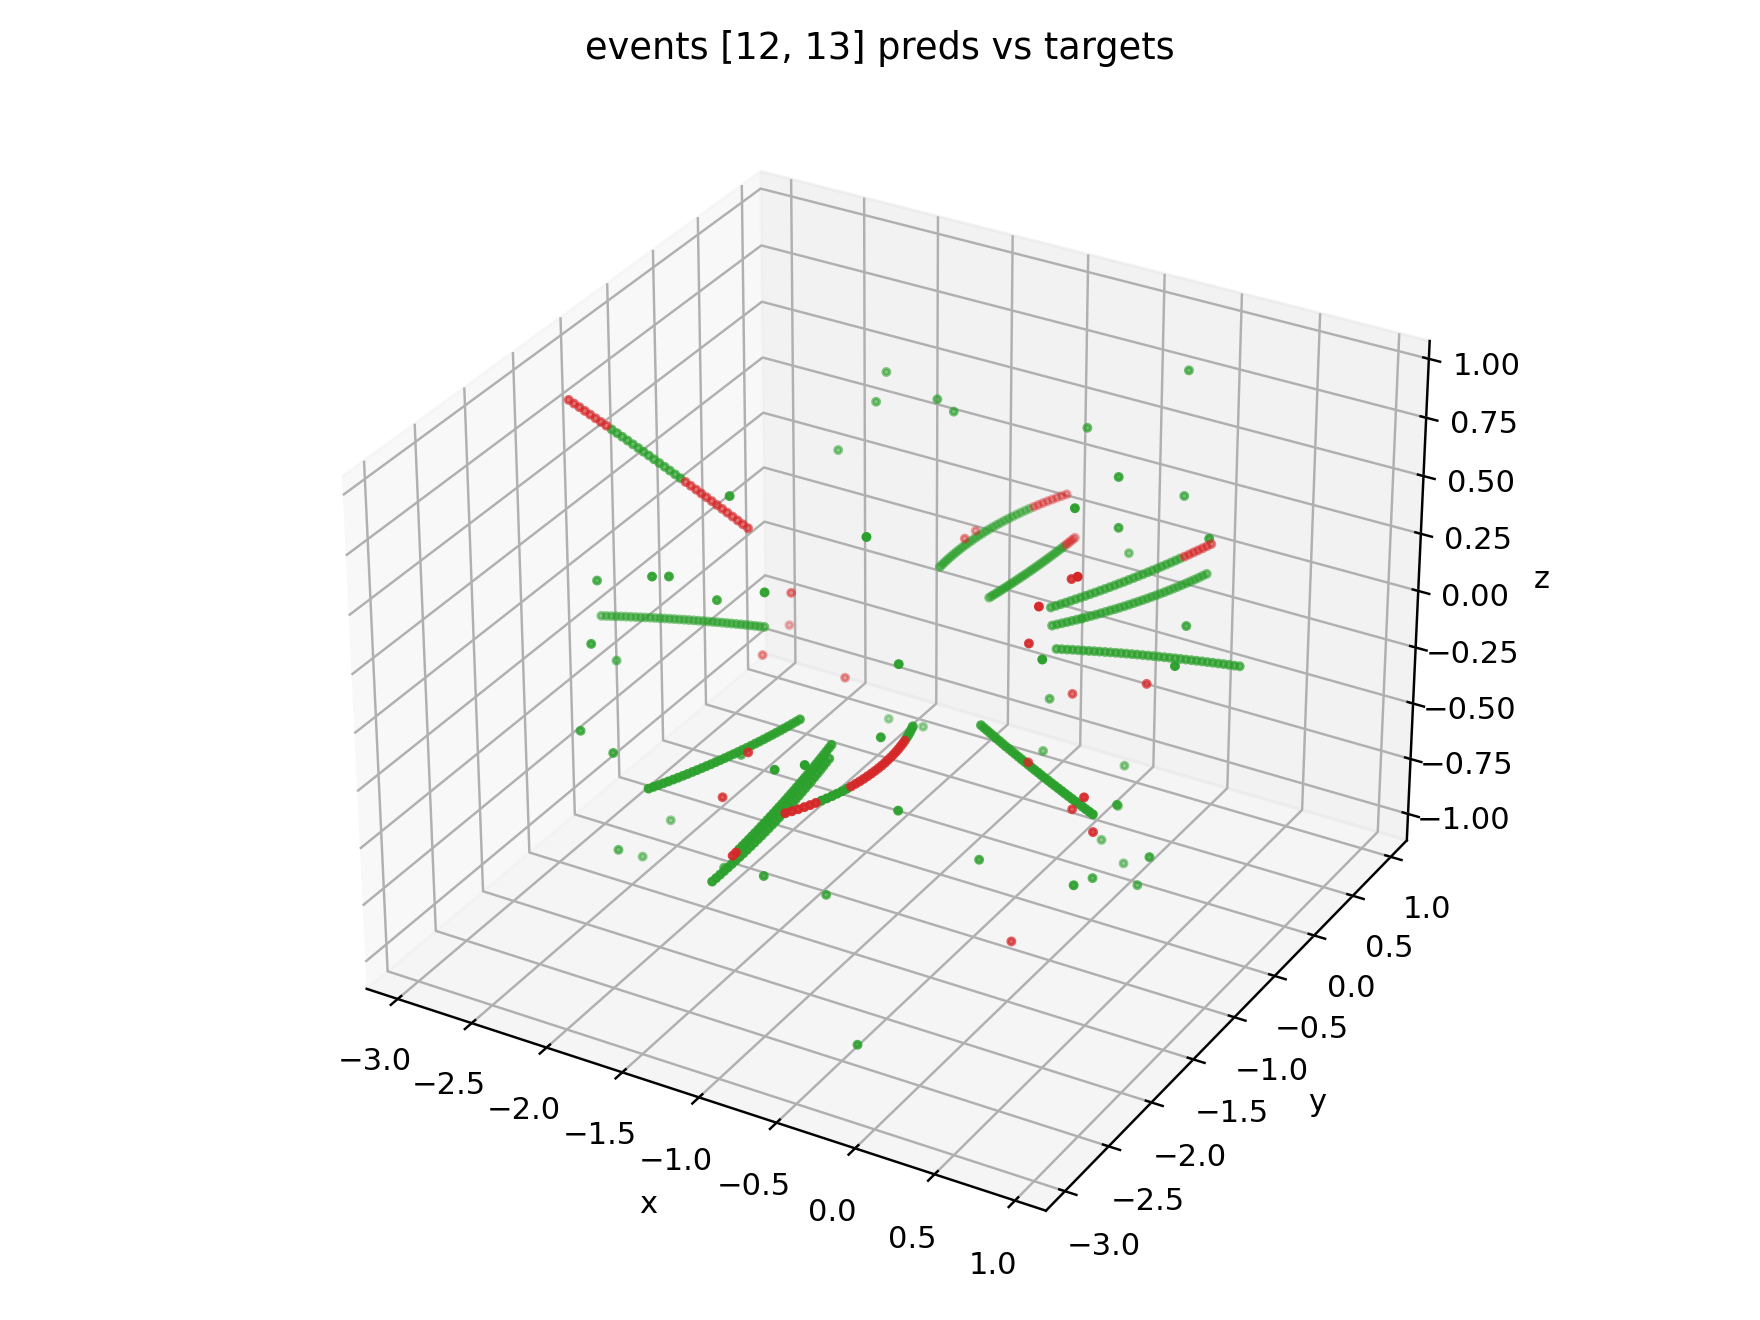

In [61]:
get_results_for_event([12, 13])

Accuracy is 0.8571428571428571 
Precision is 0.8974358974358975 
Recall is 0.9230769230769231 


<IPython.core.display.Javascript object>


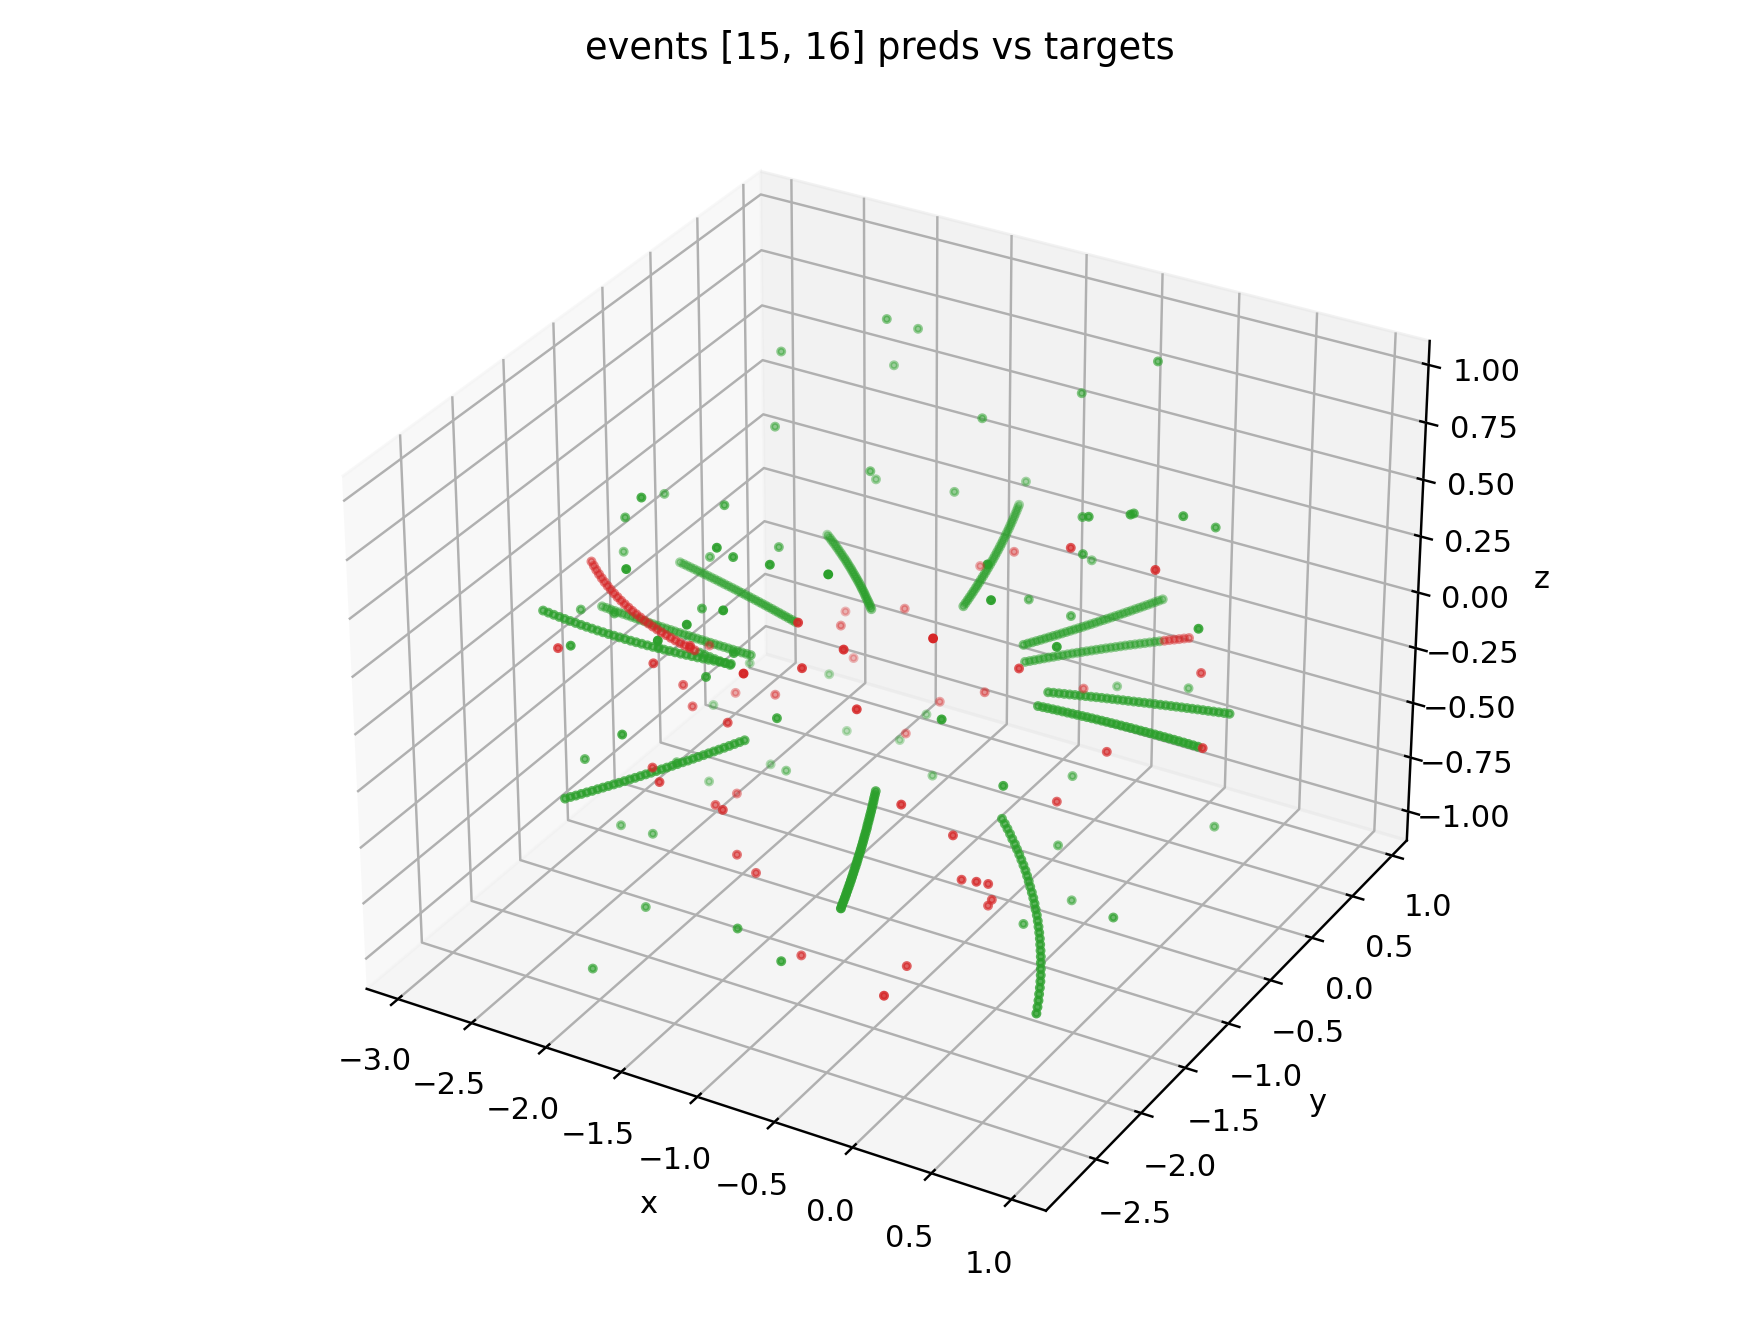

In [63]:
get_results_for_event([15, 16])

In [289]:
def get_results_for_event_masked(event_nums=[1,2]):
    event = data[data.event.isin(event_nums)]
    len_mult = len(event_nums)
    transforms = trn.Compose([
        trn.ConstraintsNormalize(use_global_constraints = True, columns=('x', 'y', 'z'), constraints = {
        'x': [-600., 600.], 'y': [-600., 600.], 'z': [-2386., 2386.]
    })])
    event_t = transforms(event)
    event_t = event_t.sample(frac = 1)
    event_x = event_t[['x', 'y', 'z']].values.T #(event_t[['r', 'phi', 'z']].values / [1., np.pi, 1.]).T
    event_y = event_t[event_t['track'] != -1]
    input_event = torch.from_numpy(np.swapaxes(event_x, -1, -2)).unsqueeze(0).float()
    event_changed = torch.zeros((input_event.size(0), 512*len_mult, input_event.size(2))) - 9.
    event_changed[:, :input_event.size(1), :input_event.size(2) ] = input_event
    mask = torch.zeros((input_event.size(0), 512*len_mult), dtype=torch.bool)
    mask[:input_event.size(1)] = 1
    inputs = {'x': event_changed, 'mask': mask }
    result = model(x=inputs['x'], mask=inputs['mask'] )
    result = result.squeeze()
    result = f.sigmoid(result) > 0.5
    result = result.to(int)[:input_event.size(1)]
    labels = (event_t['track']!=-1).astype('int')
    print(f"Accuracy is {(labels == np.array(result)).sum() / len(labels)} ")
    print(f"Precision is {(labels[labels>0.5] == np.array(result)[labels>0.5]).sum() / np.array(result).sum()} ")
    print(f"Recall is {(labels[labels>0.5] == np.array(result)[labels>0.5]).sum() / labels.sum()} ")
    mask = (result == 1)
    print(result.masked_select(mask))
    print(event_t)
    print(event_t[mask.numpy()])
    visualize_preds_targets_3d(event_t[mask.numpy()], np.array(result.masked_select(mask)), title=f'event {event_nums} preds vs targets', scatter_params_true={'c':'tab:green', 's':5}, scatter_params_false={'c':'tab:red', 's':5}, axes=['x', 'y', 'z'], titleAx=['x', 'y', 'z'])

Accuracy is 0.9294117647058824 
Precision is 0.9292035398230089 
Recall is 1.0 


<IPython.core.display.Javascript object>


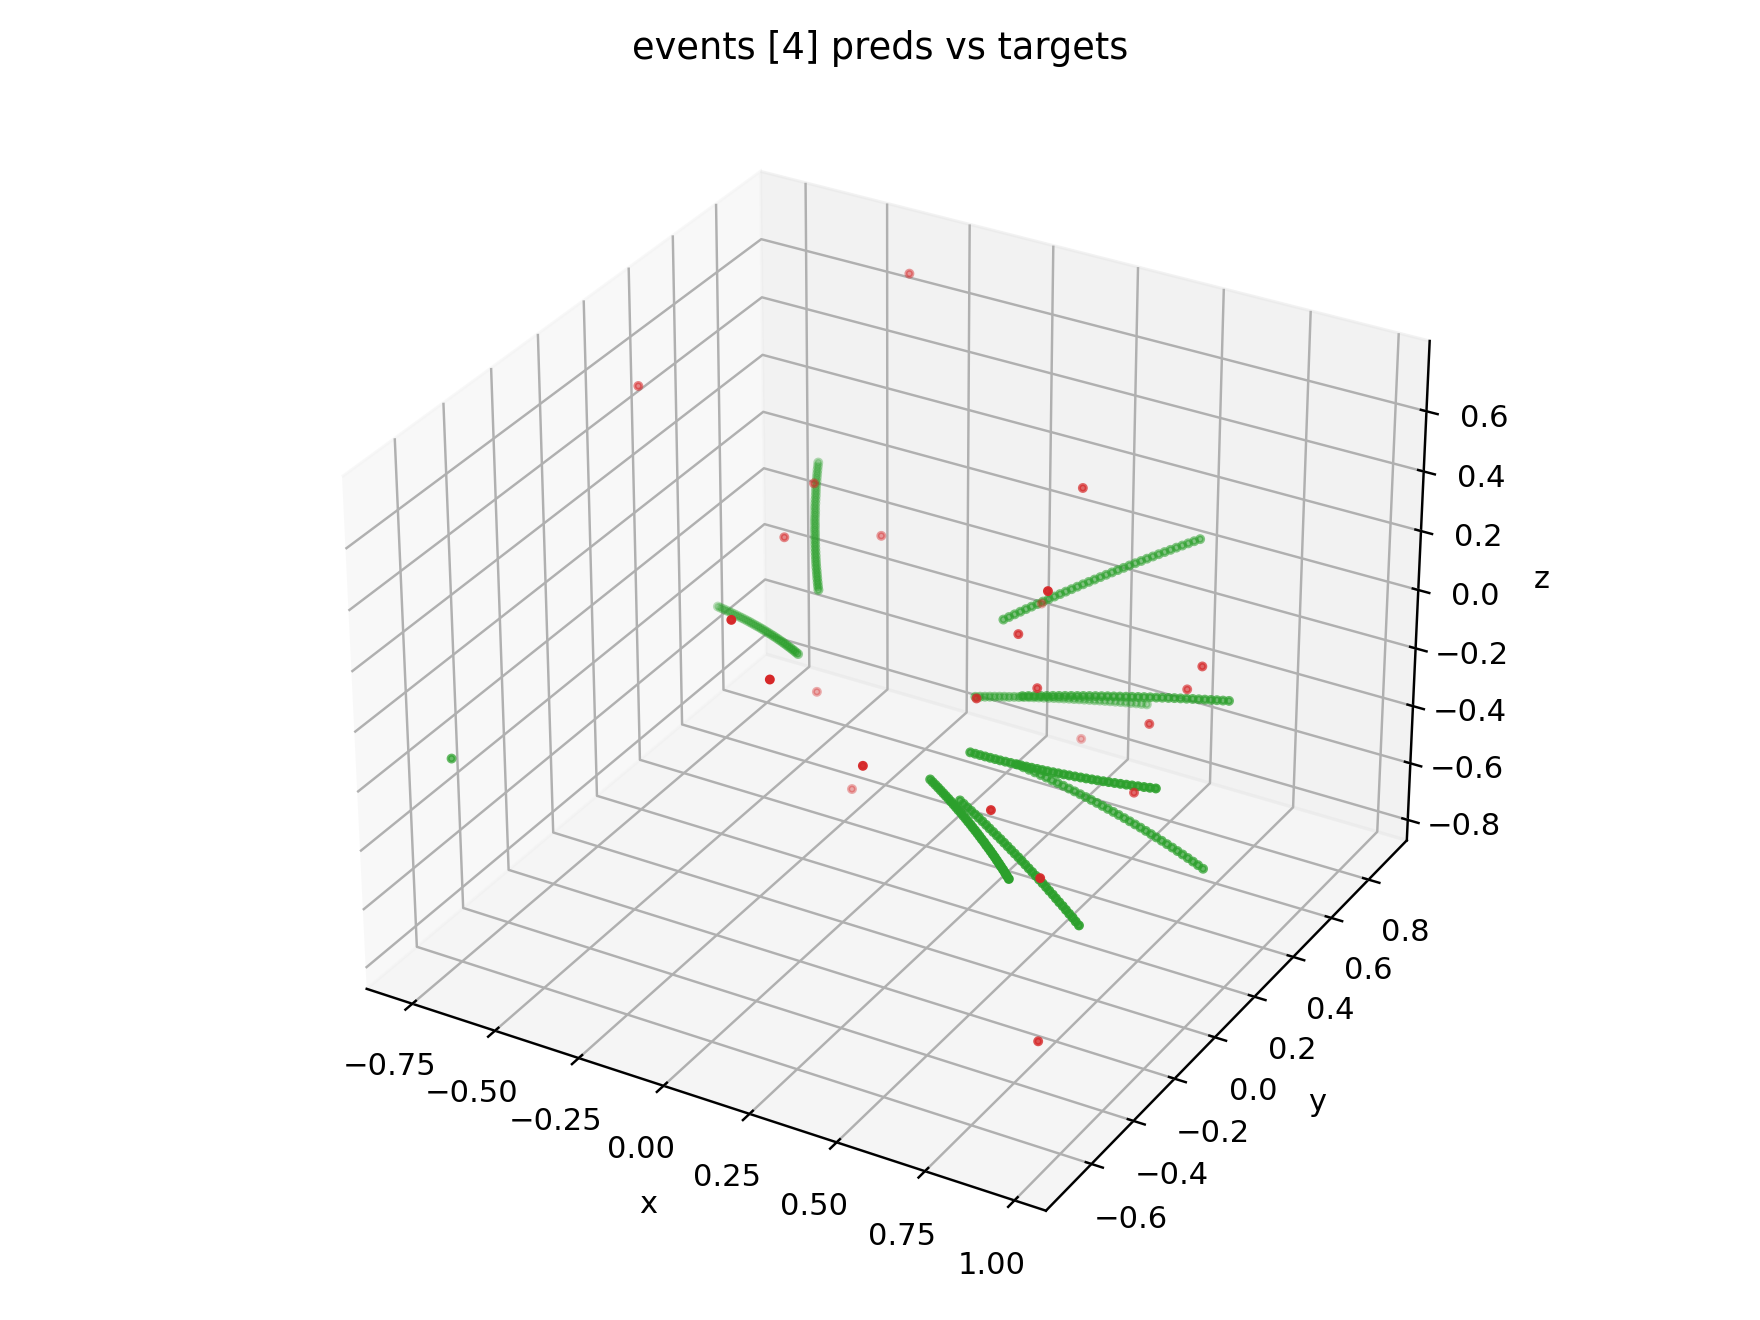

In [290]:
get_results_for_event([4])

In [ ]:
get_results_for_event_masked([4, 5])

In [291]:
import time
from tqdm.notebook import tqdm
def get_stat_results_for_event(event_nums_per_sample=2):
    len_mult = event_nums_per_sample
    precisions = []
    recalls = []
    accuracies = []
    times = []
    
    for start in tqdm(range(data.event.min(), data.event.max(), event_nums_per_sample)):
        
        event_nums = [start + i for i in range(event_nums_per_sample)]
        event = data[data.event.isin(event_nums)]
        transforms = trn.Compose([
            trn.ConstraintsNormalize(use_global_constraints = True, columns=('x', 'y', 'z'), constraints = {
            'x': [-600., 600.], 'y': [-600, 600.], 'z': [-2386., 2386.]
        })])
        event_t = transforms(event)
        event_t = event_t.sample(frac = 1)
        event_x = event_t[['x', 'y', 'z']].values.T #(event_t[['r', 'phi', 'z']].values / [1., np.pi, 1.]).T
        input_event = torch.from_numpy(np.swapaxes(event_x, -1, -2)).unsqueeze(0).float()
        event_changed = torch.zeros((input_event.size(0), 512*len_mult, input_event.size(2)))
        event_changed[:, :input_event.size(1), :input_event.size(2) ] = input_event
        mask = torch.zeros((input_event.size(0), 512*len_mult), dtype=torch.bool)
        mask[:input_event.size(1)] = 1
        inputs = {'x': event_changed, 'mask': mask }
        start_time = time.time()
        result = model(x=inputs['x'], mask=inputs['mask'] )
        result = result.squeeze()
        result = f.sigmoid(result) > 0.5
        result = result.to(int)[:input_event.size(1)]
        times.append(time.time() - start_time)
        labels = (event_t['track'] != -1).astype('int')
        
        accuracies.append((labels == np.array(result)).sum() / len(labels))
        precisions.append((labels[labels>0.5] == np.array(result)[labels>0.5]).sum() / (np.array(result).sum()+1e-6))
        recalls.append((labels[labels>0.5] == np.array(result)[labels>0.5]).sum() / (labels.sum()+1e-6))
       
    print(f"Accuracy is {np.mean(accuracies)}")
    print(f"Precision is {np.mean(precisions)} ")
    print(f"Recall is {np.mean(recalls)} ")
    print(f"Time is {np.mean(times)} ")
       # visualize_preds_targets_3d(event_t, np.array(result), title=f'events {event_nums} preds vs targets', scatter_params_true={'c':'tab:green', 's':5}, scatter_params_false={'c':'tab:red', 's':5}, axes=['x', 'y', 'z'], titleAx=['x', 'y', 'z'])

In [310]:
model = PCTSegment(n_points=1024)
# D:\projects\ariadne\lightning_logs\PCTSegment\version_37\epoch=82-step=4150.ckpt
model = weights_update(model=model,
                           checkpoint=torch.load("D:/projects/ariadne/lightning_logs/PCTSegment/version_173/epoch=0-step=125.ckpt"))


In [311]:
get_stat_results_for_event(event_nums_per_sample=2)

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy is 0.8267276586470723
Precision is 0.8176012902249647 
Recall is 0.9885937121422768 
Time is 0.18899806022644042 


In [ ]:
event_nums = [9, 10, 11, 12, 13]
visualize_simple_3d(data[data.event.isin(event_nums)], title=f'event {event_nums}', scatter_params_true={'c':'tab:green', 's':5}, scatter_params_false={'c':'tab:red', 's':5})

In [ ]:
model = PCTSegment(n_points=2560)
# D:\projects\ariadne\lightning_logs\PCTSegment\version_37\epoch=82-step=4150.ckpt
model = weights_update(model=model,
                           checkpoint=torch.load("D:/projects/ariadne/lightning_logs/PCTSegment/version_114/epoch=4-step=4000.ckpt"))


In [107]:
get_stat_results_for_event(event_nums_per_sample=5)

Accuracy is 0.7724327803996822
Precision is 0.7724327803996822 
Recall is 1.0 
Time is 1.0857162475585938 


In [108]:
1.0857162475585938 / 5

0.21714324951171876

In [ ]:
get_results_for_event([15, 16, 17, 18, 19])

Accuracy is 0.7942097026604069 
Precision is 0.7942097026604069 
Recall is 1.0 
tensor([1, 1, 1,  ..., 1, 1, 1])
      event         x         y         z  station  track          px  \
5417     19 -1.597822 -0.171600 -0.202804        5      4 -567.990439   
4610     16 -1.832219 -2.183679 -0.201188       19      3 -305.938365   
4809     17 -0.503799 -1.750857 -0.006566        1      1  249.782226   
4883     17  0.543134 -1.281656  0.087471       22     -1    0.000000   
4745     16 -0.171025 -1.695909 -0.318803        6     -1    0.000000   
...     ...       ...       ...       ...      ...    ...         ...   
4787     17  0.200484 -0.513970 -0.115767       14      0  431.642210   
4530     16  0.134327 -0.859522 -0.033012        9      1  563.027064   
4837     17  0.069523 -2.386494  0.019043       29      1  294.002555   
4718     16  0.436813 -0.448902 -0.075703       22      6  925.821094   
4873     17  0.660503 -1.315422 -0.880950       26     -1    0.000000   

          

<IPython.core.display.Javascript object>


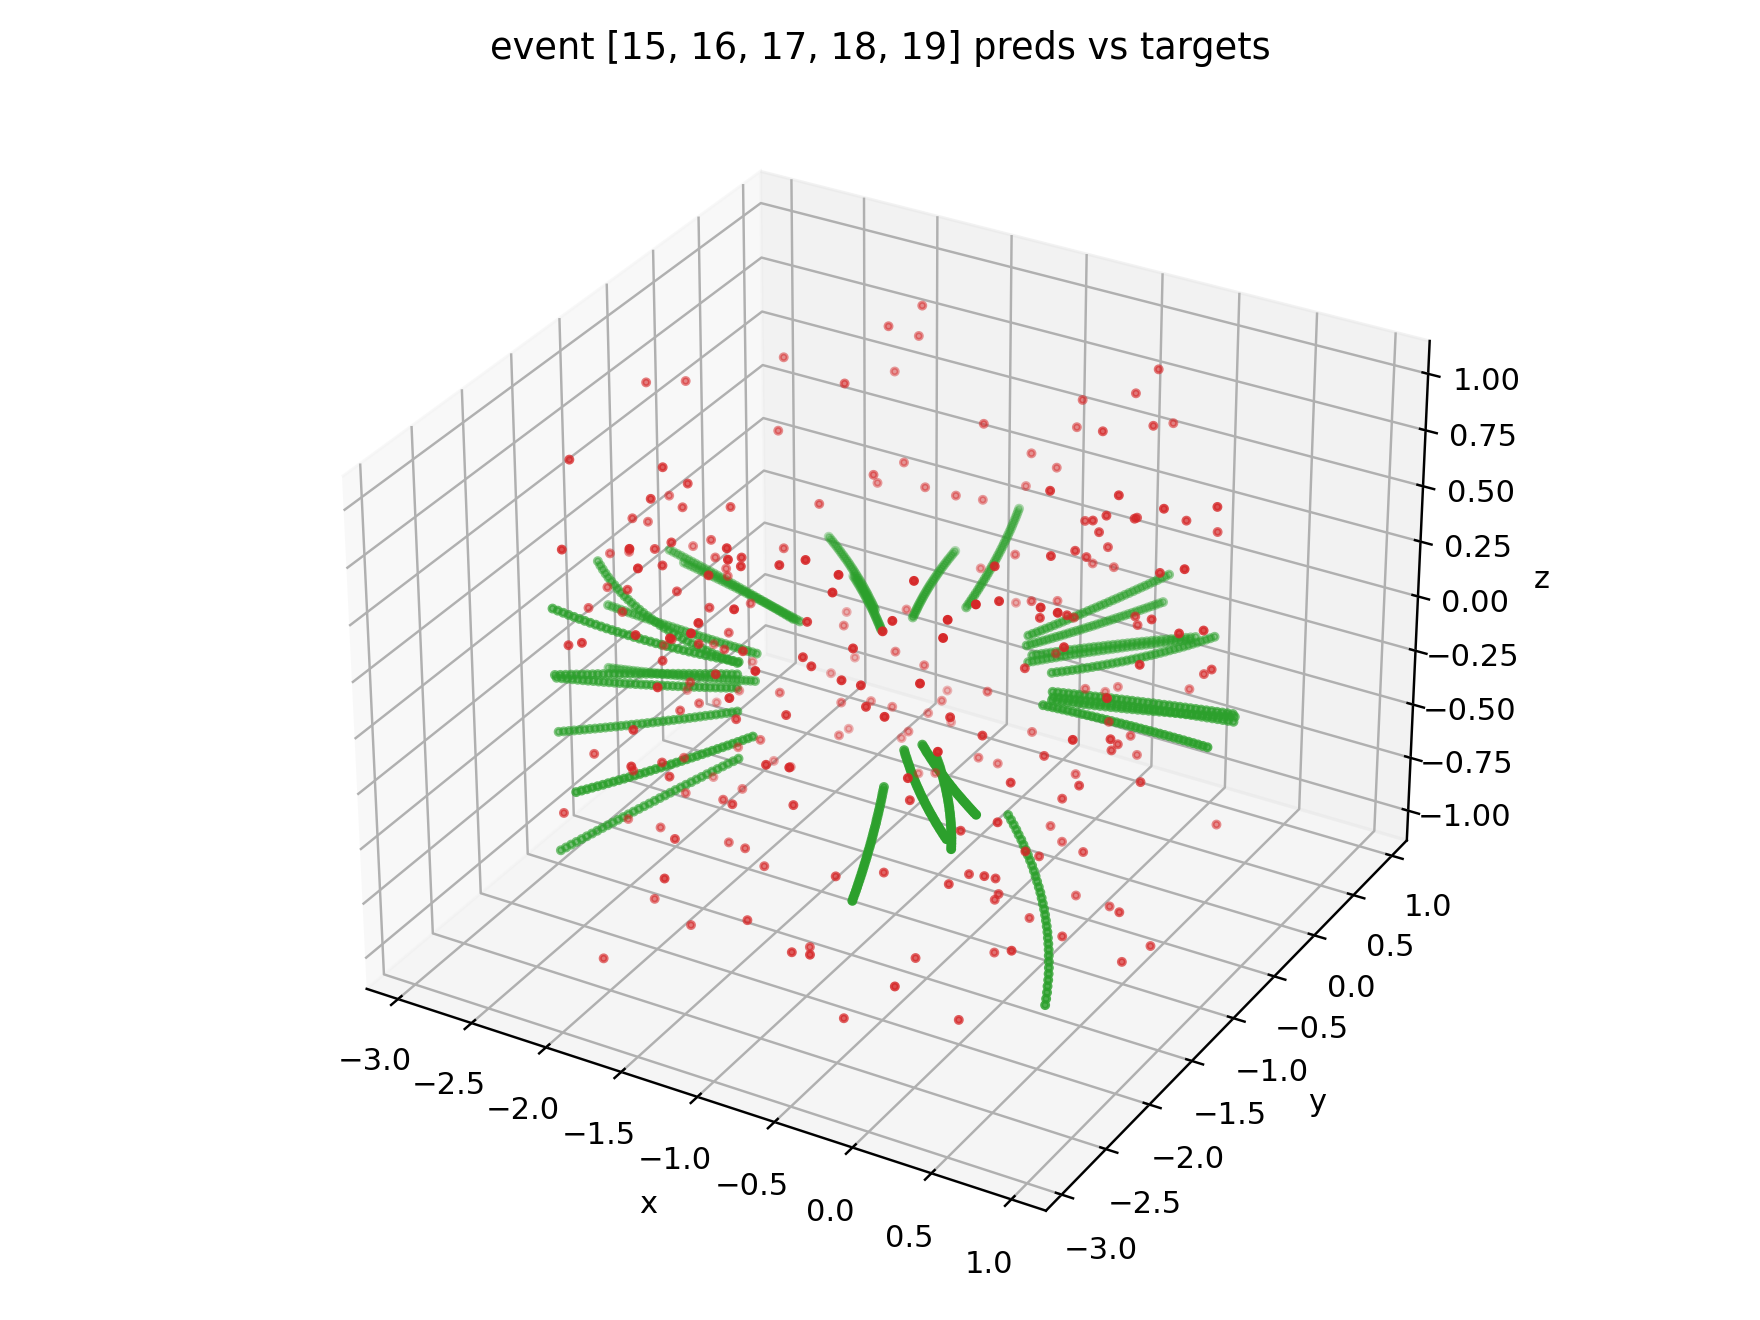

In [106]:
get_results_for_event_masked([15, 16, 17, 18, 19])

Accuracy is 0.6054421768707483 
Precision is 0.7303921568627451 
Recall is 0.7095238095238096 


<IPython.core.display.Javascript object>


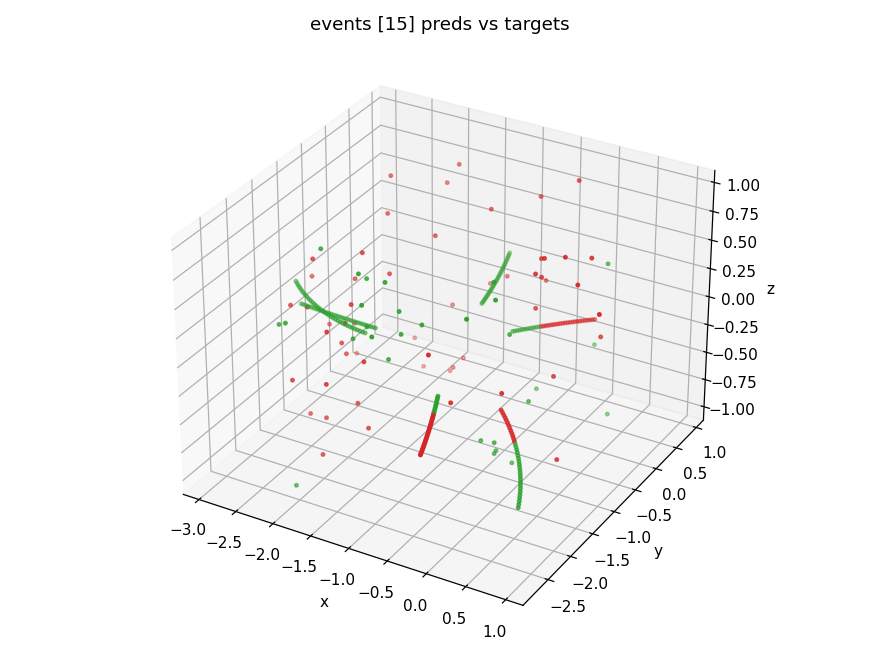

In [285]:
model = PCTSegment(n_points=512)
# D:\projects\ariadne\lightning_logs\PCTSegment\version_37\epoch=82-step=4150.ckpt
model = weights_update(model=model,
                           checkpoint=torch.load("D:/projects/ariadne/lightning_logs/PCTSegment/version_164/epoch=49-step=40000.ckpt"))
get_results_for_event([15])

In [309]:
get_stat_results_for_event(event_nums_per_sample=1)

  0%|          | 0/99 [00:00<?, ?it/s]

Accuracy is 0.7470869282500702
Precision is 0.8177400760067874 
Recall is 0.8365232136340949 
Time is 0.07324907755610918 


In [ ]:
event_t.shape

In [ ]:
mask = event_t['track'] != 1
event_t[mask]

In [147]:
from ariadne.transformer.dataset import process_pointcloud, GridConfigNew

In [110]:
model = PCTSegment(n_points=2560)
# D:\projects\ariadne\lightning_logs\PCTSegment\version_37\epoch=82-step=4150.ckpt
model = weights_update(model=model,
                           checkpoint=torch.load("D:/projects/ariadne/lightning_logs/PCTSegment/version_54/epoch=0-step=500.ckpt"))

AssertionError: key encoder.0.weight not in pretrained_dict odict_keys(['model.conv1.weight', 'model.conv2.weight', 'model.bn1.weight', 'model.bn1.bias', 'model.bn1.running_mean', 'model.bn1.running_var', 'model.bn1.num_batches_tracked', 'model.bn2.weight', 'model.bn2.bias', 'model.bn2.running_mean', 'model.bn2.running_var', 'model.bn2.num_batches_tracked', 'model.gather_local_0.conv1.weight', 'model.gather_local_0.conv2.weight', 'model.gather_local_0.bn1.weight', 'model.gather_local_0.bn1.bias', 'model.gather_local_0.bn1.running_mean', 'model.gather_local_0.bn1.running_var', 'model.gather_local_0.bn1.num_batches_tracked', 'model.gather_local_0.bn2.weight', 'model.gather_local_0.bn2.bias', 'model.gather_local_0.bn2.running_mean', 'model.gather_local_0.bn2.running_var', 'model.gather_local_0.bn2.num_batches_tracked', 'model.gather_local_1.conv1.weight', 'model.gather_local_1.conv2.weight', 'model.gather_local_1.bn1.weight', 'model.gather_local_1.bn1.bias', 'model.gather_local_1.bn1.running_mean', 'model.gather_local_1.bn1.running_var', 'model.gather_local_1.bn1.num_batches_tracked', 'model.gather_local_1.bn2.weight', 'model.gather_local_1.bn2.bias', 'model.gather_local_1.bn2.running_mean', 'model.gather_local_1.bn2.running_var', 'model.gather_local_1.bn2.num_batches_tracked', 'model.linear1.weight', 'model.bn6.weight', 'model.bn6.bias', 'model.bn6.running_mean', 'model.bn6.running_var', 'model.bn6.num_batches_tracked', 'model.linear2.weight', 'model.linear2.bias', 'model.bn7.weight', 'model.bn7.bias', 'model.bn7.running_mean', 'model.bn7.running_var', 'model.bn7.num_batches_tracked', 'model.linear3.weight', 'model.linear3.bias', 'model.pt_last.conv1.weight', 'model.pt_last.conv2.weight', 'model.pt_last.bn1.weight', 'model.pt_last.bn1.bias', 'model.pt_last.bn1.running_mean', 'model.pt_last.bn1.running_var', 'model.pt_last.bn1.num_batches_tracked', 'model.pt_last.bn2.weight', 'model.pt_last.bn2.bias', 'model.pt_last.bn2.running_mean', 'model.pt_last.bn2.running_var', 'model.pt_last.bn2.num_batches_tracked', 'model.pt_last.sa1.q_conv.weight', 'model.pt_last.sa1.k_conv.weight', 'model.pt_last.sa1.v_conv.weight', 'model.pt_last.sa1.v_conv.bias', 'model.pt_last.sa1.trans_conv.weight', 'model.pt_last.sa1.trans_conv.bias', 'model.pt_last.sa1.after_norm.weight', 'model.pt_last.sa1.after_norm.bias', 'model.pt_last.sa1.after_norm.running_mean', 'model.pt_last.sa1.after_norm.running_var', 'model.pt_last.sa1.after_norm.num_batches_tracked', 'model.pt_last.sa2.q_conv.weight', 'model.pt_last.sa2.k_conv.weight', 'model.pt_last.sa2.v_conv.weight', 'model.pt_last.sa2.v_conv.bias', 'model.pt_last.sa2.trans_conv.weight', 'model.pt_last.sa2.trans_conv.bias', 'model.pt_last.sa2.after_norm.weight', 'model.pt_last.sa2.after_norm.bias', 'model.pt_last.sa2.after_norm.running_mean', 'model.pt_last.sa2.after_norm.running_var', 'model.pt_last.sa2.after_norm.num_batches_tracked', 'model.pt_last.sa3.q_conv.weight', 'model.pt_last.sa3.k_conv.weight', 'model.pt_last.sa3.v_conv.weight', 'model.pt_last.sa3.v_conv.bias', 'model.pt_last.sa3.trans_conv.weight', 'model.pt_last.sa3.trans_conv.bias', 'model.pt_last.sa3.after_norm.weight', 'model.pt_last.sa3.after_norm.bias', 'model.pt_last.sa3.after_norm.running_mean', 'model.pt_last.sa3.after_norm.running_var', 'model.pt_last.sa3.after_norm.num_batches_tracked', 'model.pt_last.sa4.q_conv.weight', 'model.pt_last.sa4.k_conv.weight', 'model.pt_last.sa4.v_conv.weight', 'model.pt_last.sa4.v_conv.bias', 'model.pt_last.sa4.trans_conv.weight', 'model.pt_last.sa4.trans_conv.bias', 'model.pt_last.sa4.after_norm.weight', 'model.pt_last.sa4.after_norm.bias', 'model.pt_last.sa4.after_norm.running_mean', 'model.pt_last.sa4.after_norm.running_var', 'model.pt_last.sa4.after_norm.num_batches_tracked', 'model.conv_fuse.0.weight', 'model.conv_fuse.1.weight', 'model.conv_fuse.1.bias', 'model.conv_fuse.1.running_mean', 'model.conv_fuse.1.running_var', 'model.conv_fuse.1.num_batches_tracked', 'model.lbr1.0.weight', 'model.lbr1.0.bias', 'model.lbr1.1.weight', 'model.lbr1.1.bias', 'model.lbr1.1.running_mean', 'model.lbr1.1.running_var', 'model.lbr1.1.num_batches_tracked', 'model.lbr2.0.weight', 'model.lbr2.0.bias', 'model.lbr2.1.weight', 'model.lbr2.1.bias', 'model.lbr2.1.running_mean', 'model.lbr2.1.running_var', 'model.lbr2.1.num_batches_tracked', 'model.linear_last.weight', 'model.linear_last.bias'])!

In [114]:
cfg = GridConfigNew(
        xrange=(0., 1.), yrange=(0., 1.), zrange=(0., 1.), vd=0.5, vh=0.5, vw=0.5,
    )

In [127]:
event = data[data.event.isin([1,2])]
event.describe()

event           x           y            z     station  \
count  682.000000  682.000000  682.000000   682.000000  682.000000   
mean     1.532258   47.745750   57.021446     6.371626   17.709677   
std      0.499325  264.706361  335.654367   654.251163    9.975779   
min      1.000000 -575.531791 -574.037957 -2279.723548    1.000000   
25%      1.000000 -149.480779 -279.766130  -281.094223    9.000000   
50%      2.000000   41.886783  186.993066    46.745236   18.000000   
75%      2.000000  275.965855  351.557280   262.337152   26.000000   
max      2.000000  542.756591  574.754783  2316.081845   35.000000   

            track          px          py           pz          X0  \
count  682.000000  682.000000  682.000000   682.000000  682.000000   
mean     2.695015   75.502405   29.794092  -105.022149   -6.516812   
std      2.701107  217.951834  416.370064   379.207075   11.395853   
min     -1.000000 -211.156520 -940.387462 -1107.720959  -20.046785   
25%      0.000000 -125.083014 -130.497463  -103.513687  -20.046785   
50%      3.000000    0.000000    0.000000    -4.791147    0.000000   
75%      5.000000  264.282985  315.963270   108.783348    4.173693   
max      7.000000  540.971583  916.979742   423.804168    4.173693   

               Y0          Z0  label  
count  682.000000  682.000000    0.0  
mean    -5.225867   15.186506    NaN  
std      3.212624   38.007438    NaN  
min     -8.667671  -22.681505    NaN  
25%     -8.667671  -22.681505    NaN  
50%     -4.061049    0.000000    NaN  
75%     -4.061049   59.671495    NaN  
max      0.000000   59.671495    NaN

In [130]:
transforms = trn.Compose([
        trn.ConstraintsNormalize(use_global_constraints = True, columns=('x', 'y', 'z'), constraints = {
        'x': [-600., 600.], 'y': [-600, 600.], 'z': [-2386., 2386.]
    })])
event_t = transforms(event)
event_t.describe()

event           x           y           z     station       track  \
count  682.000000  682.000000  682.000000  682.000000  682.000000  682.000000   
mean     1.532258    0.079576    0.095036    0.002670   17.709677    2.695015   
std      0.499325    0.441177    0.559424    0.274204    9.975779    2.701107   
min      1.000000   -0.959220   -0.956730   -0.955458    1.000000   -1.000000   
25%      1.000000   -0.249135   -0.466277   -0.117810    9.000000    0.000000   
50%      2.000000    0.069811    0.311655    0.019591   18.000000    3.000000   
75%      2.000000    0.459943    0.585929    0.109949   26.000000    5.000000   
max      2.000000    0.904594    0.957925    0.970696   35.000000    7.000000   

               px          py           pz          X0          Y0  \
count  682.000000  682.000000   682.000000  682.000000  682.000000   
mean    75.502405   29.794092  -105.022149   -6.516812   -5.225867   
std    217.951834  416.370064   379.207075   11.395853    3.212624   
min   -211.156520 -940.387462 -1107.720959  -20.046785   -8.667671   
25%   -125.083014 -130.497463  -103.513687  -20.046785   -8.667671   
50%      0.000000    0.000000    -4.791147    0.000000   -4.061049   
75%    264.282985  315.963270   108.783348    4.173693   -4.061049   
max    540.971583  916.979742   423.804168    4.173693    0.000000   

               Z0  label       index  
count  682.000000    0.0  682.000000  
mean    15.186506    NaN  491.500000  
std     38.007438    NaN  197.020726  
min    -22.681505    NaN  151.000000  
25%    -22.681505    NaN  321.250000  
50%      0.000000    NaN  491.500000  
75%     59.671495    NaN  661.750000  
max     59.671495    NaN  832.000000

In [148]:
def visualize_preds_targets_3d_tensor(data_true,
                               preds,
                               labels,
                               axes=['x','y','z'], 
                               titleAx=['X', 'Y', 'Z'], 
                               title=None, 
                               scatter_params_true=None, 
                               scatter_params_false=None,
                               ):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    if not scatter_params_true:
        scatter_params_true = {}
    if not scatter_params_false:
        scatter_params_true = {}
    print(data_true.shape)
    true_els = data_true[labels==preds]
    false_els = data_true[labels!=preds]
    ax.scatter(true_els[:, 0], true_els[:,1],true_els[:,2], **scatter_params_true)
    ax.scatter(false_els[:, 0], false_els[:, 1], false_els[:, 2], **scatter_params_false)
    
    ax.set_xlabel(titleAx[0])
    ax.set_ylabel(titleAx[1])
    ax.set_zlabel(titleAx[2])
    if title:
        plt.title(title)
    plt.tight_layout()
    plt.show()

In [153]:
def get_results_for_event_voxels(cfg, event_nums=[1,2], sample_len = 256):
    len_mult = len(event_nums)
    event = data[data.event.isin(event_nums)]
    transforms = trn.Compose([
        trn.ConstraintsNormalize(use_global_constraints = True, columns=('x', 'y', 'z'), constraints = {
        'x': [-600., 600.], 'y': [-600, 600.], 'z': [-2386., 2386.]
    })])
    event_t = transforms(event)
    event_t = event_t.sample(frac = 1)
    event_x = event_t[['x', 'y', 'z']].values
    event_y = (event_t['track'] != -1).astype(np.float32)
    processed_event = process_pointcloud(event_x, targets=event_y, cfg=cfg, max_points_per_voxel=sample_len)
    batch_inputs = np.array(processed_event['x'])
    batch_masks = np.array(processed_event['mask'])
    batch_targets = np.array(processed_event['labels']).astype(np.float32)
    batch_targets = np.expand_dims(batch_targets, -1)
    
    inputs = {'x': torch.from_numpy(batch_inputs), 'mask': torch.from_numpy(batch_masks)}
    result = model(x=inputs['x'], mask=inputs['mask'] )
    result = result.squeeze()
    result = f.sigmoid(result) > 0.5
    result = result.to(int)
    result = result.squeeze()
    batch_masks = batch_masks.squeeze()
    batch_inputs = torch.from_numpy(batch_inputs)[batch_masks==1]
    batch_targets = torch.from_numpy(batch_targets).squeeze()
    result = result[batch_masks==1]
    batch_targets = batch_targets[batch_masks==1]
    print(f"Accuracy is {(batch_targets == result).sum() / len(batch_targets)} ")
    print(f"Precision is {(batch_targets.masked_select(batch_targets>0.5) == result.masked_select(batch_targets>0.5)).sum() / result.sum()} ")
    print(f"Recall is {(batch_targets.masked_select(batch_targets>0.5) == result.masked_select(batch_targets>0.5)).sum() / batch_targets.sum()} ")
    visualize_preds_targets_3d_tensor(batch_inputs, result.numpy(), batch_targets.numpy(), title=f'events {event_nums} preds vs targets', scatter_params_true={'c':'tab:green', 's':5}, scatter_params_false={'c':'tab:red', 's':5}, axes=['x', 'y', 'z'], titleAx=['x', 'y', 'z'])

In [150]:
model = PCTSegment(n_points=256, input_channels=6)
# D:\projects\ariadne\lightning_logs\PCTSegment\version_37\epoch=82-step=4150.ckpt
model = weights_update(model=model,
                           checkpoint=torch.load("D:/projects/ariadne/lightning_logs/PCTSegment/version_166/epoch=2-step=6000.ckpt"))

Accuracy is 0.9285714030265808 
Precision is 0.9436619877815247 
Recall is 0.9571428298950195 


<IPython.core.display.Javascript object>


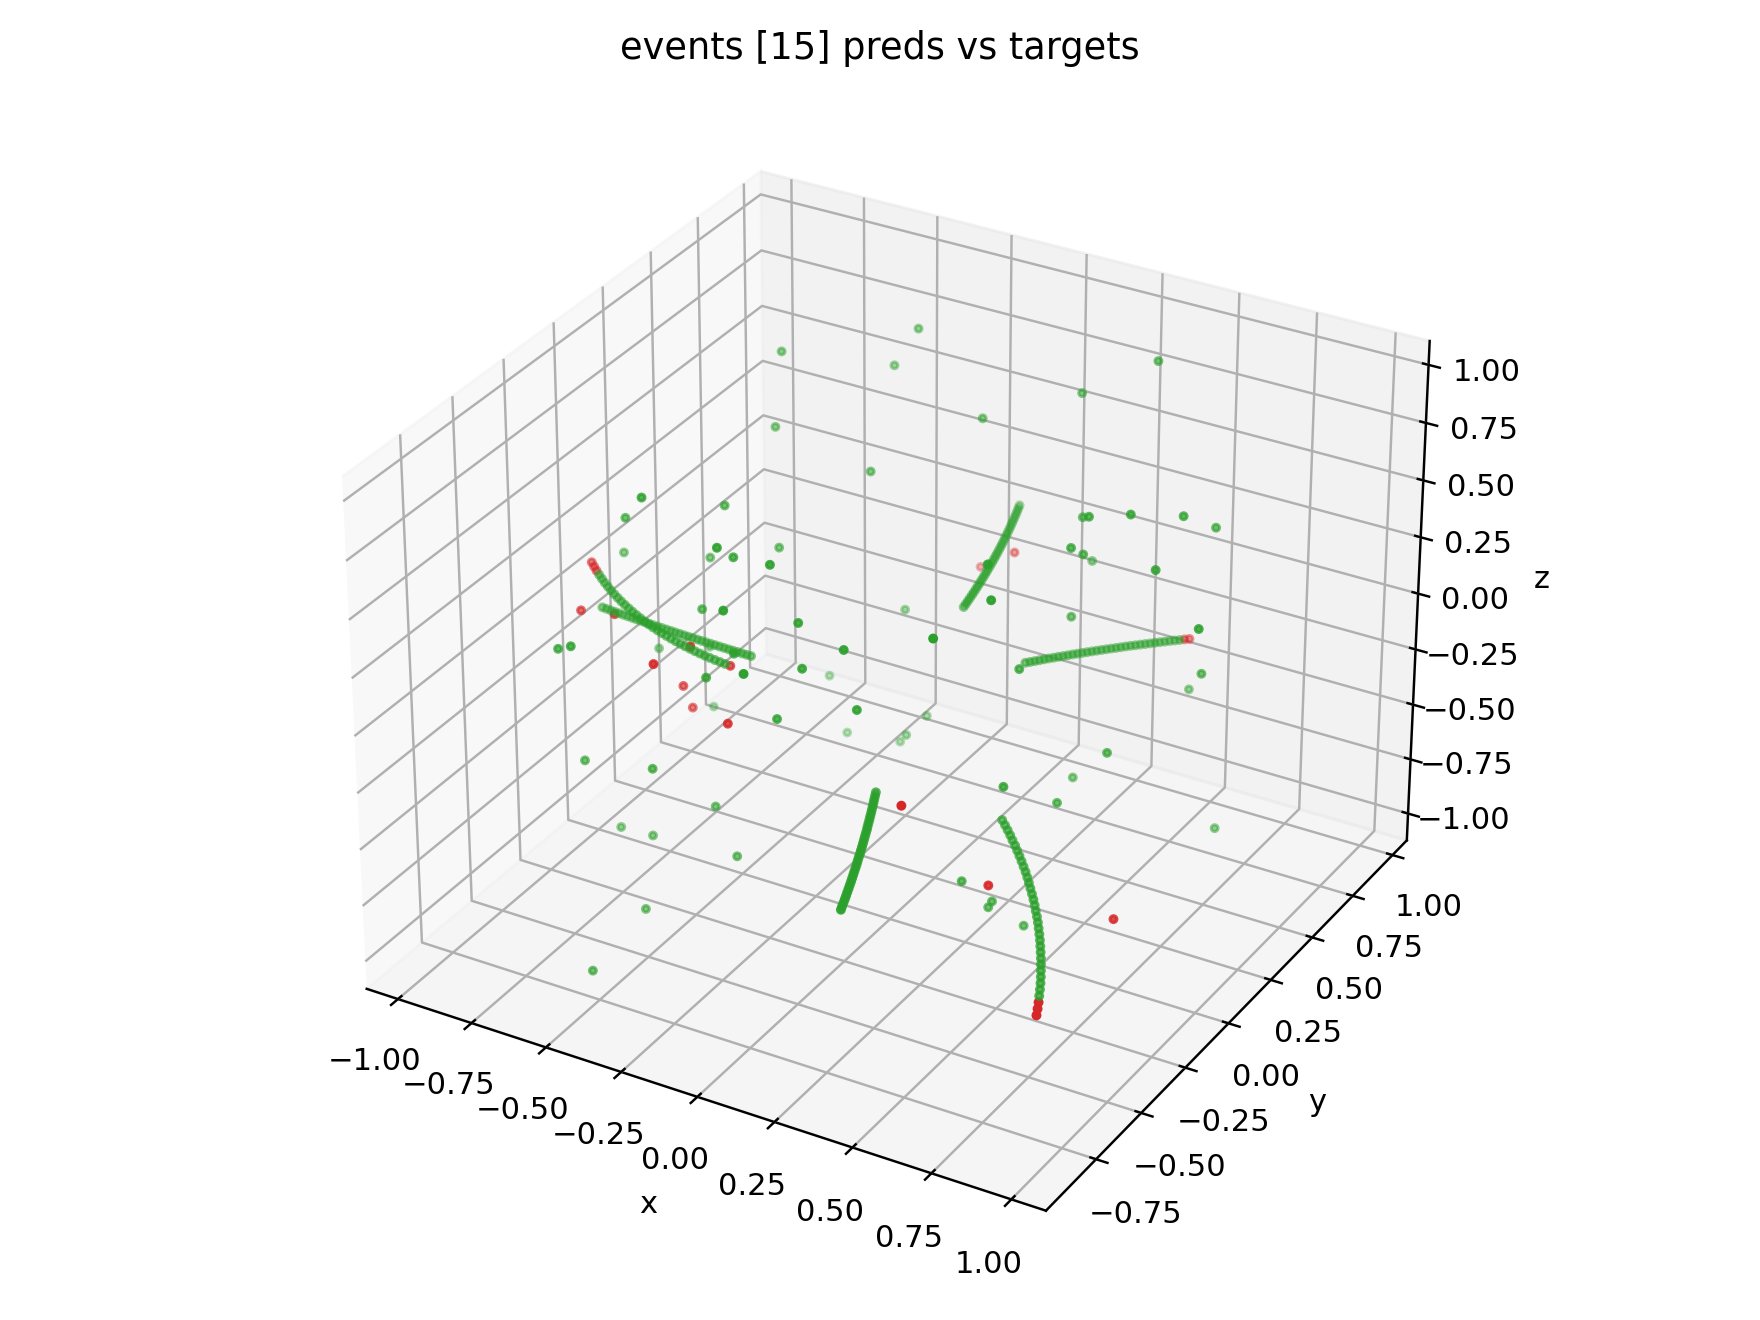

torch.Size([294, 6])


In [154]:
cfg = GridConfigNew(
        xrange=(-1., 1.), yrange=(-1., 1.), zrange=(-1., 1.), vx=0.5, vy=0.5, vz=1.,
    )
get_results_for_event_voxels(cfg, event_nums=[15], sample_len = 256)

In [201]:
get_results_for_event_voxels(cfg, event_nums=[14], sample_len = 256)

IndexError: too many indices for tensor of dimension 3

In [305]:
def prepare_voxels(event, cfg, sample_len: int = 512):
    transforms = trn.Compose([
    trn.ConstraintsNormalize(use_global_constraints = True, columns=('x', 'y', 'z'), constraints = {
    'x': [-600., 600.], 'y': [-600, 600.], 'z': [-2386., 2386.]
    })])
    event_t = transforms(event)
    event_t = event_t.sample(frac = 1)
    event_x = event_t[['x', 'y', 'z']].values
    event_y = (event_t['track'] != -1).astype(np.float32)
    processed_event = process_pointcloud(event_x, targets=event_y, cfg=cfg, max_points_per_voxel=sample_len)
    return processed_event

In [306]:
def get_results_for_event(event, cfg, sample_len: int = 512):
    processed_event = prepare_voxels(event=event, cfg=cfg, sample_len=sample_len)
    batch_inputs = torch.from_numpy(np.array(processed_event['x']))
    batch_masks = torch.from_numpy(np.array(processed_event['mask'])).bool()
    batch_targets = np.array(processed_event['labels']).astype(np.float32)
    batch_targets = np.expand_dims(batch_targets, -1)
    inputs = {'x': batch_inputs, 'mask': batch_masks}
    
    start_time = time.time()
    result = model(x=inputs['x'], mask=inputs['mask'] )
    result = (f.sigmoid(result) > 0.5).to(int)
    print(result)
    print(result.shape)
    print(result.sum())
    print(batch_masks.shape)
    
    print(batch_masks.sum())
    print(result[batch_masks.unsqueeze(-1)].sum() )
    times.append(time.time() - start_time)
    return result, times

In [307]:
def get_stat_results_for_event_voxel(event_nums_per_sample=2, sample_len=256):
    len_mult = event_nums_per_sample
    precisions = []
    recalls = []
    accuracies = []
    times = []
    
    for start in tqdm(range(data.event.min(), data.event.max(), event_nums_per_sample)):
            event_nums = [start + i for i in range(event_nums_per_sample)]
            
            event = data[data.event.isin(event_nums)]
            processed_event = prepare_voxels(event=event, cfg=cfg, sample_len=sample_len)
            batch_inputs = torch.from_numpy(np.array(processed_event['x']))
            batch_masks = torch.from_numpy(np.array(processed_event['mask'])).bool()
            batch_targets = np.array(processed_event['labels'])
            batch_targets = torch.from_numpy(np.expand_dims(batch_targets, -1)).int()
            inputs = {'x': batch_inputs, 'mask': batch_masks}

            start_time = time.time()
            result = model(x=inputs['x'], mask=inputs['mask'] )
            result = (f.sigmoid(result) > 0.5).to(int)
            times.append(time.time() - start_time)
            batch_targets = batch_targets[batch_masks]
            result = result[batch_masks]

            accuracies.append((batch_targets == result).sum() / len(batch_targets))
            precisions.append((batch_targets.masked_select(batch_targets>0.5) == result.masked_select(batch_targets>0.5)).sum() / result.sum())
            recalls.append((batch_targets.masked_select(batch_targets>0.5) == result.masked_select(batch_targets>0.5)).sum() / batch_targets.sum())
    print(f"Accuracy is {np.mean(accuracies)}")
    print(f"Precision is {np.mean(precisions)} ")
    print(f"Recall is {np.mean(recalls)} ")
    print(f"Time is {np.mean(times)} ")
       # visualize_preds_targets_3d(event_t, np.array(result), title=f'events {event_nums} preds vs targets', scatter_params_true={'c':'tab:green', 's':5}, scatter_params_false={'c':'tab:red', 's':5}, axes=['x', 'y', 'z'], titleAx=['x', 'y', 'z'])

In [260]:
model = PCTSegment(n_points=128, input_channels=6)
# D:\projects\ariadne\lightning_logs\PCTSegment\version_37\epoch=82-step=4150.ckpt
model = weights_update(model=model,
                           checkpoint=torch.load("D:/projects/ariadne/lightning_logs/PCTSegment/version_161/epoch=6-step=5600.ckpt"))

In [308]:
get_stat_results_for_event_voxel(event_nums_per_sample=2, sample_len=324)

  0%|          | 0/99 [00:00<?, ?it/s]

Accuracy is 0.9618496894836426
Precision is 0.9622967839241028 
Recall is 0.9826483726501465 
Time is 0.06597123242387867 


294
(294, 3)
Accuracy is 0.9455782175064087 
Precision is 0.9490740895271301 
Recall is 0.976190447807312 


<IPython.core.display.Javascript object>


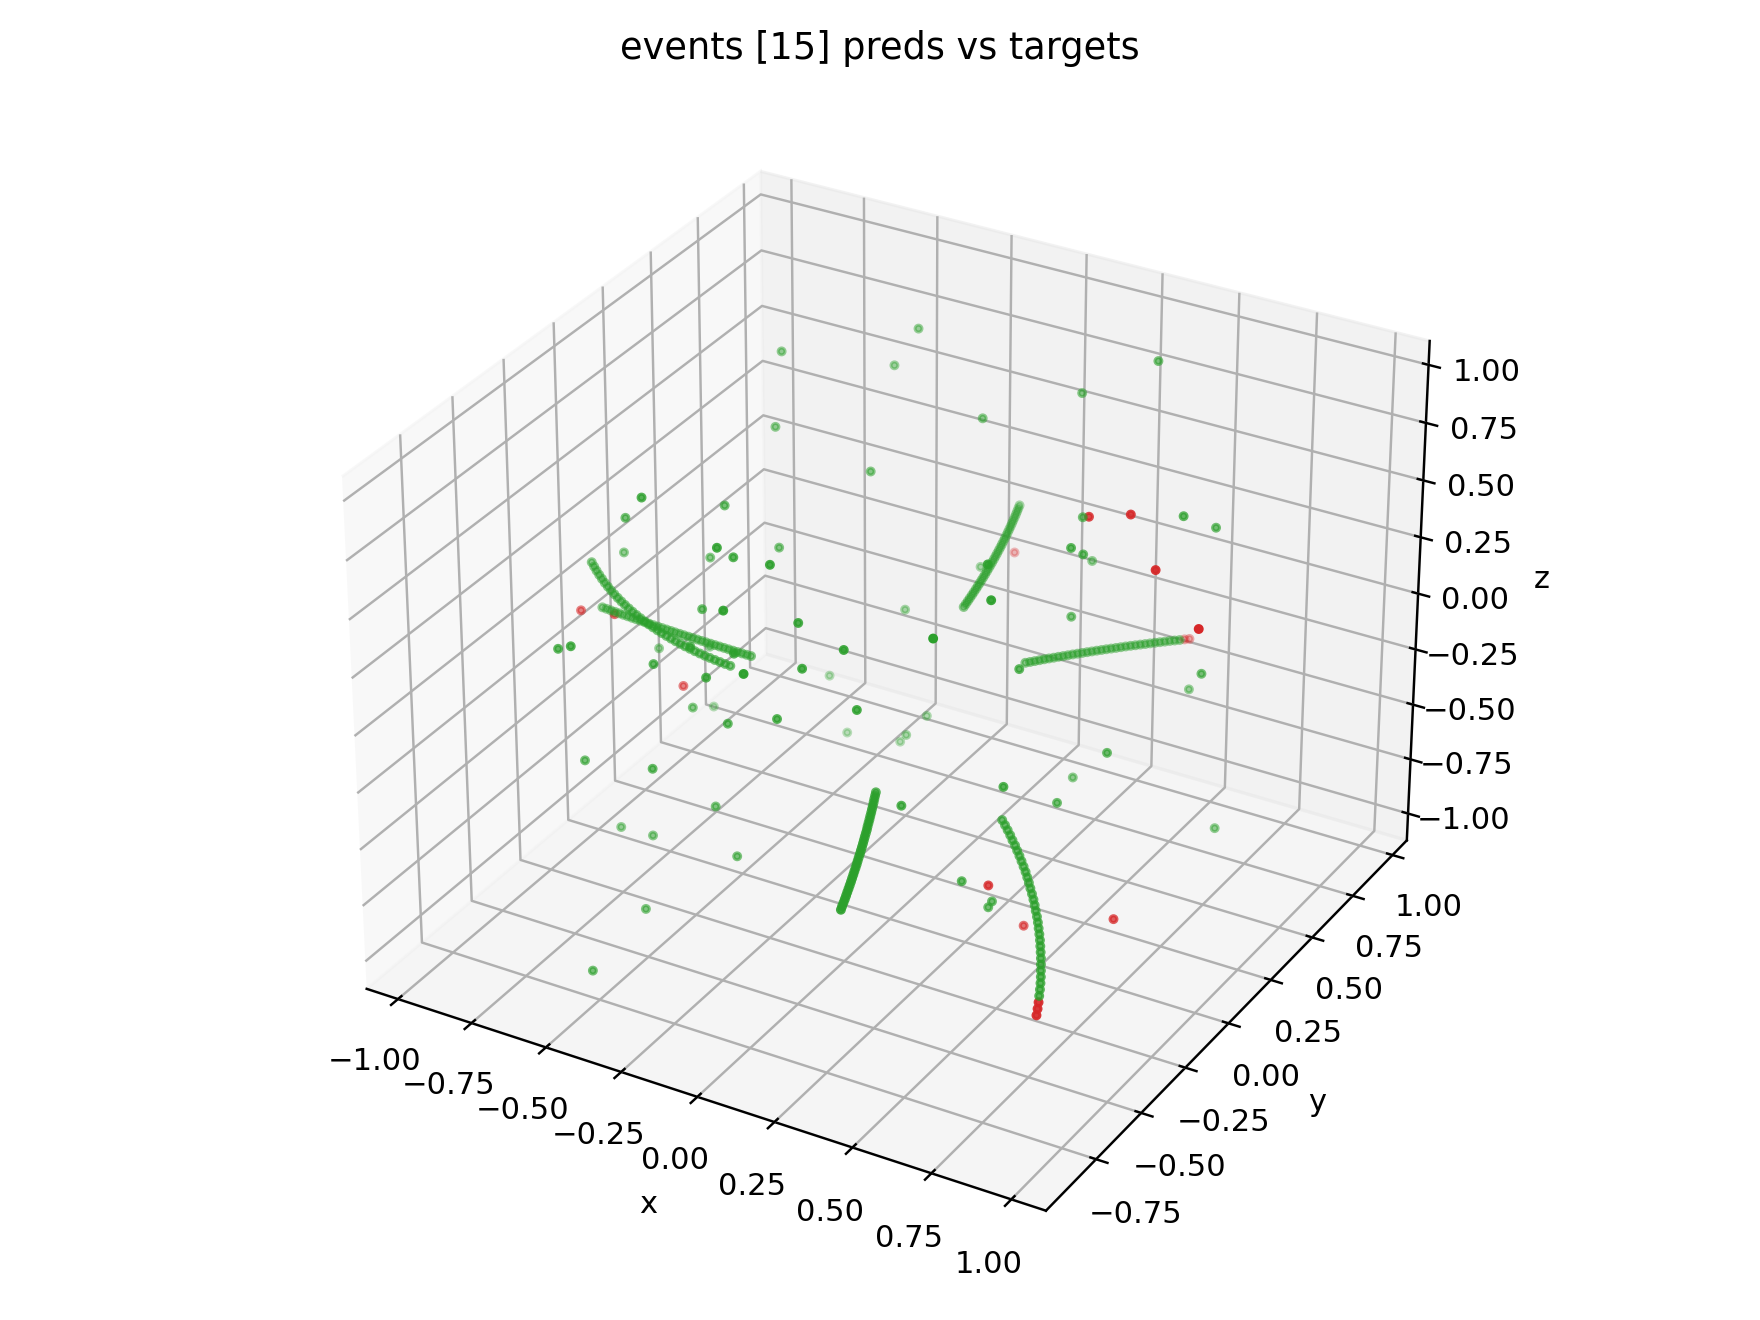

torch.Size([294, 6])


In [261]:
cfg = GridConfigNew(
        xrange=(-1., 1.), yrange=(-1., 1.), zrange=(-1., 1.), vd=0.5, vh=0.5, vw=0.5,
    )
get_results_for_event_voxels(cfg, event_nums=[15], sample_len = 128)

In [266]:
get_stat_results_for_event_voxel(event_nums_per_sample=1, sample_len=128)

  0%|          | 0/99 [00:00<?, ?it/s]

(151, 3)
(319, 3)
(363, 3)
(139, 3)
(340, 3)
[4]
(241, 3)
[5]
(269, 3)
(368, 3)
(368, 3)
(303, 3)
[9]
(317, 3)
(161, 3)
(275, 3)
(220, 3)
(359, 3)
(294, 3)
(287, 3)
(148, 3)
(351, 3)
(198, 3)
[19]
(225, 3)
(333, 3)
(307, 3)
(175, 3)
(351, 3)
(260, 3)
(245, 3)
(109, 3)
[27]
(165, 3)
[28]
(52, 3)
[29]
(358, 3)
(263, 3)
(107, 3)
(108, 3)
(181, 3)
(198, 3)
(329, 3)
[36]
(333, 3)
(130, 3)
[38]
(98, 3)
(307, 3)
(271, 3)
(156, 3)
[42]
(340, 3)
(344, 3)
(270, 3)
[45]
(301, 3)
(339, 3)
(99, 3)
(316, 3)
(56, 3)
[50]
(136, 3)
(110, 3)
(350, 3)
(271, 3)
(95, 3)
[55]
(218, 3)
(362, 3)
(155, 3)
(119, 3)
(229, 3)
(163, 3)
(359, 3)
(167, 3)
(206, 3)
[64]
(179, 3)
(283, 3)
(178, 3)
(347, 3)
(222, 3)
(217, 3)
(190, 3)
(366, 3)
(305, 3)
(148, 3)
(180, 3)
(332, 3)
[76]
(150, 3)
(201, 3)
(307, 3)
(303, 3)
(292, 3)
(239, 3)
(111, 3)
(238, 3)
(138, 3)
[85]
(327, 3)
(299, 3)
(116, 3)
[88]
(205, 3)
(207, 3)
(290, 3)
[91]
(299, 3)
(183, 3)
(310, 3)
(170, 3)
[95]
(276, 3)
[96]
(311, 3)
(225, 3)
Accuracy is 0.973

In [295]:
model = PCTSegment(n_points=324, input_channels=6)
# D:\projects\ariadne\lightning_logs\PCTSegment\version_37\epoch=82-step=4150.ckpt
model = weights_update(model=model,
                           checkpoint=torch.load("D:/projects/ariadne/lightning_logs/PCTSegment/version_172/epoch=1-step=500.ckpt"))

ariadne.transformer.dataset.GridConfigNew

In [297]:
cfg = GridConfigNew(
        xrange=(-1., 1.), yrange=(-1., 1.), zrange=(-1., 1.), vz=1., vx=1., vy=1.,
    )
get_results_for_event_voxels(cfg, event_nums=[15], sample_len = 324)

IndexError: too many indices for tensor of dimension 3

In [267]:

model = PCTSegment(n_points=512, input_channels=6)
# D:\projects\ariadne\lightning_logs\PCTSegment\version_37\epoch=82-step=4150.ckpt
model = weights_update(model=model,
                           checkpoint=torch.load("D:/projects/ariadne/lightning_logs/PCTSegment/version_162/epoch=4-step=4000.ckpt"))

1278
(1278, 3)
Accuracy is 0.9467918872833252 
Precision is 0.9522445201873779 
Recall is 0.9822660088539124 


<IPython.core.display.Javascript object>


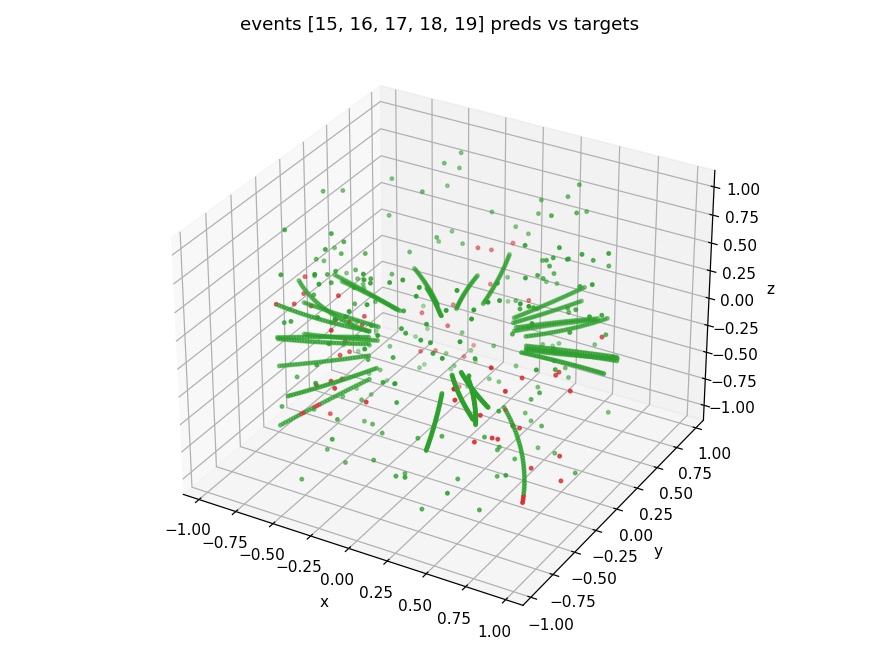

torch.Size([1278, 6])


In [269]:
cfg = GridConfigNew(
        xrange=(-1., 1.), yrange=(-1., 1.), zrange=(-1., 1.), vd=0.5, vh=0.5, vw=0.5,
    )
get_results_for_event_voxels(cfg, event_nums=[15, 16,17, 18, 19], sample_len = 512)

  0%|          | 0/20 [00:00<?, ?it/s]

(1312, 3)
[0, 1, 2, 3, 4]
(1549, 3)
[5, 6, 7, 8, 9]
(1332, 3)
[10, 11, 12, 13, 14]
(1278, 3)
[15, 16, 17, 18, 19]
(1391, 3)
[20, 21, 22, 23, 24]
(831, 3)
[25, 26, 27, 28, 29]
(1017, 3)
[30, 31, 32, 33, 34]
(1088, 3)
[35, 36, 37, 38, 39]
(1418, 3)
[40, 41, 42, 43, 44]
(1325, 3)
[45, 46, 47, 48, 49]
(923, 3)
[50, 51, 52, 53, 54]
(949, 3)
[55, 56, 57, 58, 59]
(1124, 3)
[60, 61, 62, 63, 64]
(1209, 3)
[65, 66, 67, 68, 69]
(1226, 3)
[70, 71, 72, 73, 74]
(1170, 3)
[75, 76, 77, 78, 79]
(1183, 3)
[80, 81, 82, 83, 84]
(1085, 3)
[85, 86, 87, 88, 89]
(1289, 3)
[90, 91, 92, 93, 94]
(1164, 3)
[95, 96, 97, 98, 99]
Accuracy is nan
Precision is nan 
Recall is nan 
Time is nan 


In [302]:
def get_stat_results_for_event_voxel(event_nums_per_sample=2, sample_len=256):
    len_mult = event_nums_per_sample
    precisions = []
    recalls = []
    accuracies = []
    times = []
    
    for start in tqdm(range(data.event.min(), data.event.max(), event_nums_per_sample)):
        event_nums = [start + i for i in range(event_nums_per_sample)]

        event = data[data.event.isin(event_nums)]
        transforms = trn.Compose([
        trn.ConstraintsNormalize(use_global_constraints = True, columns=('x', 'y', 'z'), constraints = {
        'x': [-600., 600.], 'y': [-600, 600.], 'z': [-2386., 2386.]
        })])
        event_t = transforms(event)
        event_t = event_t.sample(frac = 1)
        event_x = event_t[['x', 'y', 'z']].values
        event_y = (event_t['track'] != -1).astype(np.float32)
        processed_event = process_pointcloud(event_x, targets=event_y, cfg=cfg, max_points_per_voxel=sample_len)
        batch_inputs = np.array(processed_event['x'])
        batch_masks = np.array(processed_event['mask'])
        batch_targets = np.array(processed_event['labels']).astype(np.float32)
        batch_targets = np.expand_dims(batch_targets, -1)


        inputs = {'x': torch.from_numpy(batch_inputs), 'mask': torch.from_numpy(batch_masks)}

        start_time = time.time()
        result = model(x=inputs['x'], mask=inputs['mask'] )
        result = result.squeeze()
        result = f.sigmoid(result) > 0.5
        result = result.to(int)
        result = result.squeeze()
        times.append(time.time() - start_time)
        batch_masks = batch_masks.squeeze()
        batch_inputs = torch.from_numpy(batch_inputs)[batch_masks==1]
        batch_targets = torch.from_numpy(batch_targets).squeeze()
        result = result[batch_masks==1]
        batch_targets = batch_targets[batch_masks==1]

        accuracies.append((batch_targets == result).sum() / len(batch_targets))
        precisions.append((batch_targets.masked_select(batch_targets>0.5) == result.masked_select(batch_targets>0.5)).sum() / result.sum())
        recalls.append((batch_targets.masked_select(batch_targets>0.5) == result.masked_select(batch_targets>0.5)).sum() / batch_targets.sum())
    print(f"Accuracy is {np.mean(accuracies)}")
    print(f"Precision is {np.mean(precisions)} ")
    print(f"Recall is {np.mean(recalls)} ")
    print(f"Time is {np.mean(times)} ")
       # visualize_preds_targets_3d(event_t, np.array(result), title=f'events {event_nums} preds vs targets', scatter_params_true={'c':'tab:green', 's':5}, scatter_params_false={'c':'tab:red', 's':5}, axes=['x', 'y', 'z'], titleAx=['x', 'y', 'z'])

In [303]:
get_stat_results_for_event_voxel(event_nums_per_sample=1, sample_len=324)

  0%|          | 0/99 [00:00<?, ?it/s]

IndexError: too many indices for tensor of dimension 3

Accuracy is 0.8222996515679443 
Precision is 0.8849206349206349 
Recall is 0.9102040816326531 


<IPython.core.display.Javascript object>


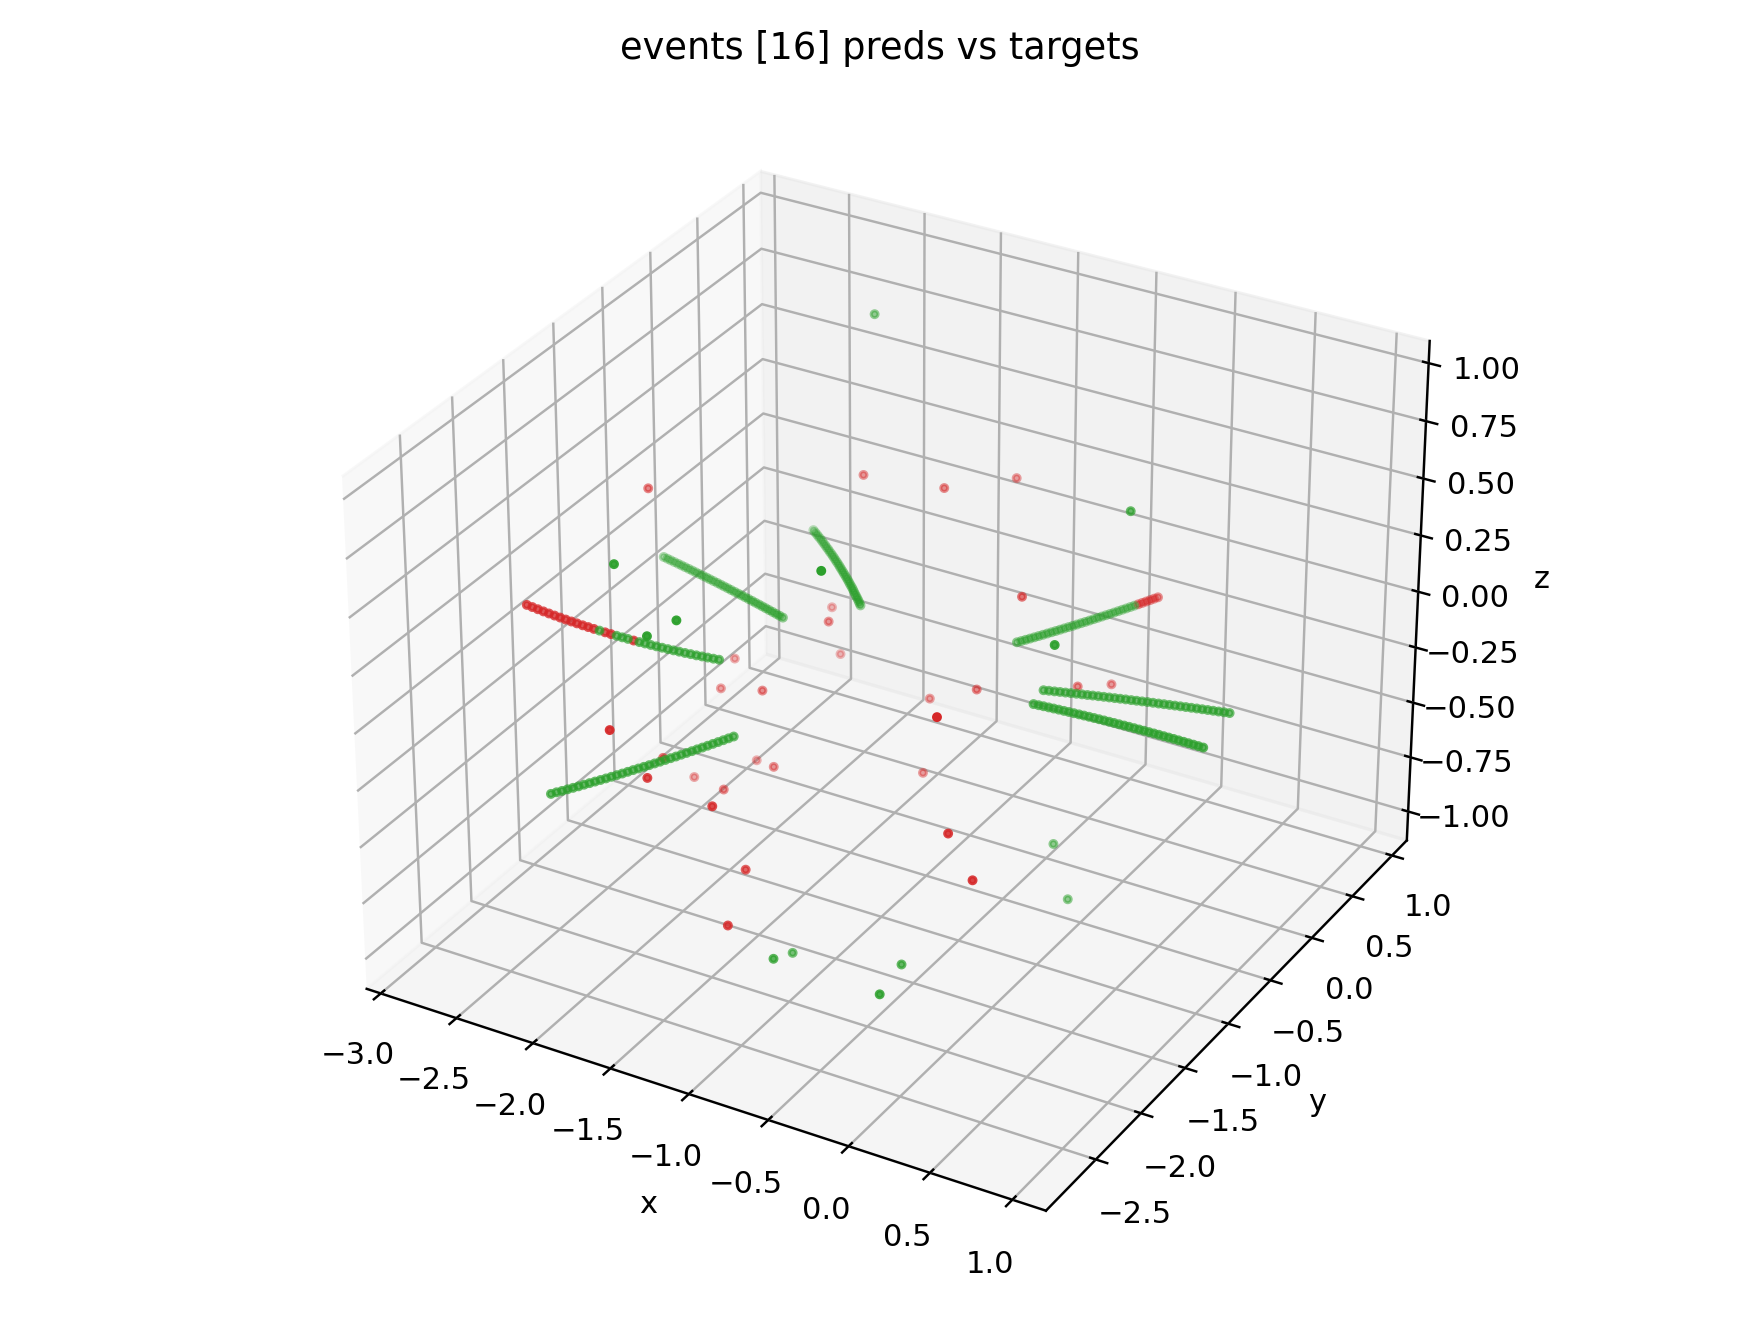

In [292]:


model = PCTSegment(n_points=512, input_channels=3)
# D:\projects\ariadne\lightning_logs\PCTSegment\version_37\epoch=82-step=4150.ckpt
model = weights_update(model=model,
                           checkpoint=torch.load("D:/projects/ariadne/lightning_logs/PCTSegment/version_165/epoch=6-step=14000.ckpt"))

get_results_for_event([16])